In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from scipy.stats import cauchy
from math import pi
import seaborn
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import math

from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.utils import broadcast_all

In [3]:
m = torch.distributions.cauchy.Cauchy(0, 1, validate_args=None)
test__ = torch.exp(m.log_prob(torch.tensor([i/100 for i in range(-400, 400)])))

## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

In [4]:
# Initial parameters: (0.1, 5), (-5, 5) il ne marche pas
# Create dataset
#dataset = SineData(amplitude_range=(-1., 1.),
#                   shift_range=(-5, 5),
#                   num_samples=2000) Pas mal pour Cauchy

In [73]:
"""
from datasets import CauchyData

dataset = CauchyData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
x, y = dataset[i] 
plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5, label="One data sample")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)
"""

'\nfrom datasets import CauchyData\n\ndataset = CauchyData(amplitude_range=(-1., 1.),\n                   shift_range=(-.5, .5),\n                   num_samples=2000)\n\n# Visualize data samples\nx, y = dataset[i] \nplt.plot(x.numpy(), y.numpy(), c=\'b\', alpha=0.5, label="One data sample")\nplt.legend(loc=\'upper center\', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)\n\nfor i in range(64):\n    x, y = dataset[i] \n    plt.plot(x.numpy(), y.numpy(), c=\'b\', alpha=0.5)\n    plt.xlim(-pi, pi)\n'

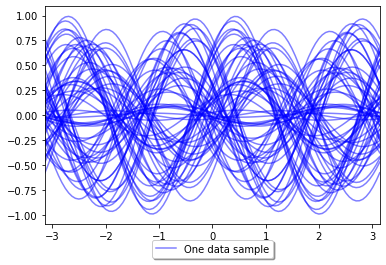

In [74]:
from datasets import SineData

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-0.5, 0.5),
                   num_samples=2000)

# Visualize data samples
x, y = dataset[0]
plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5, label="One data sample")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)


### Build Neural Process

$(x_i, y_i)_{i=1, n}$ form the context points

$r_i = h(x_i, y_i)$ is the representation

Latent distribution z that parametrizes the single order-invariant global representation z (that we want to obtain).

In [75]:
from neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

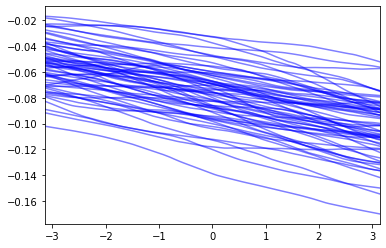

In [76]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))  #x_target est juste un ensemble de points uniformément espacés sur [-pi, pi]
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)   z_sample est un ensemble de 50 random points
    # Map x_target and z to p_y_target (which is parameterized by a normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample) #Decoder(x_dim, z_dim, h_dim, y_dim)
    # Plot predicted mean at each target point (note we could also sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [9]:
#plt.plot(z_sample.numpy()[0])
#plt.plot(x_target.numpy()[0])

### Train Neural Process

In [20]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 2
num_context = 4
num_target = 4

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
total_loss, epoch_loss = np_trainer.train(data_loader, 30)

iteration 200, loss -2.916
iteration 400, loss -4.424
iteration 600, loss -7.534
iteration 800, loss -2.095
iteration 1000, loss -8.004
Epoch: 0, Avg_loss: 1.2810738263130188
iteration 1200, loss -2.333
iteration 1400, loss 13.212
iteration 1600, loss -9.124
iteration 1800, loss -7.782
iteration 2000, loss -7.933
Epoch: 1, Avg_loss: -2.475340618222952
iteration 2200, loss -1.922
iteration 2400, loss -0.880
iteration 2600, loss -3.527
iteration 2800, loss -5.928
iteration 3000, loss -2.511
Epoch: 2, Avg_loss: -2.5639014943540097
iteration 3200, loss -2.074
iteration 3400, loss -6.538
iteration 3600, loss -0.920
iteration 3800, loss -1.050
iteration 4000, loss -0.200
Epoch: 3, Avg_loss: -3.137646074131131
iteration 4200, loss -5.595
iteration 4400, loss -9.258
iteration 4600, loss -8.358
iteration 4800, loss -8.806
iteration 5000, loss -4.243
Epoch: 4, Avg_loss: -3.0698760330975055
iteration 5200, loss -2.598
iteration 5400, loss -2.960
iteration 5600, loss -1.844
iteration 5800, loss -3

<Figure size 720x360 with 0 Axes>

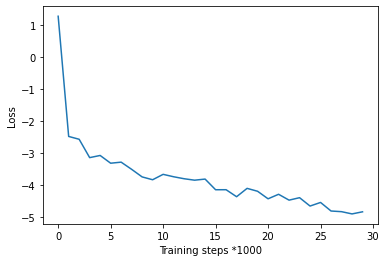

In [21]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.set_xlabel("Training steps *1000")
ax.set_ylabel("Loss")
plt.plot(epoch_loss)

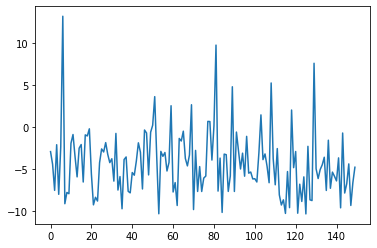

In [22]:
plt.plot(total_loss)

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

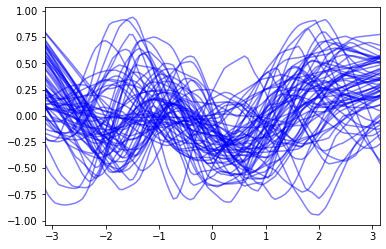

In [23]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

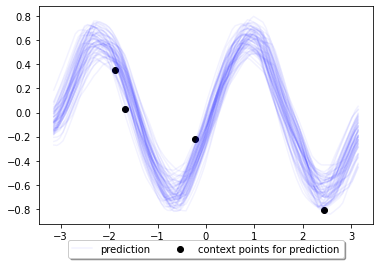

In [30]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    if i==1:
        plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b', label='prediction')
    else:
        plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k', label='context points for prediction')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

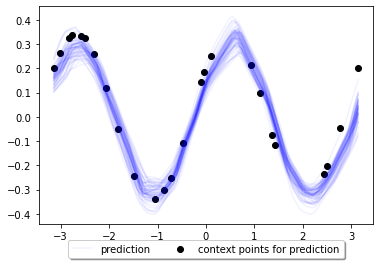

In [19]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    if i==1:
        plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b', label='prediction')
    else:
        plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k', label='context points for prediction')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

# Mean squared error

In [77]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer
from utils import context_target_split
num_tests = 64

1
1
iteration 200, loss 0.736
iteration 400, loss 1.796
iteration 600, loss 0.665
iteration 800, loss 0.880
iteration 1000, loss -0.047
Epoch: 0, Avg_loss: 1.1010818771054036
iteration 1200, loss 1.050
iteration 1400, loss 0.239
iteration 1600, loss 0.118
iteration 1800, loss 1.408
iteration 2000, loss -0.417
Epoch: 1, Avg_loss: 1.0414638166767545
iteration 2200, loss -0.217
iteration 2400, loss -0.781
iteration 2600, loss 1.518
iteration 2800, loss 1.865
iteration 3000, loss 1.291
Epoch: 2, Avg_loss: 0.9455649110539817
iteration 3200, loss 2.591
iteration 3400, loss 0.564
iteration 3600, loss 0.284
iteration 3800, loss 3.787
iteration 4000, loss 0.282
Epoch: 3, Avg_loss: 0.9781856099031866
iteration 4200, loss 1.645
iteration 4400, loss 1.418
iteration 4600, loss 0.557
iteration 4800, loss -0.004
iteration 5000, loss 0.981
Epoch: 4, Avg_loss: 0.9288550964710303
iteration 5200, loss 1.229
iteration 5400, loss 0.876
iteration 5600, loss 1.601
iteration 5800, loss 1.165
iteration 6000, l

iteration 7200, loss 0.015
iteration 7400, loss 3.118
iteration 7600, loss 5.211
iteration 7800, loss 3.061
iteration 8000, loss 3.737
Epoch: 7, Avg_loss: 1.9556010932698846
iteration 8200, loss 4.153
iteration 8400, loss 3.040
iteration 8600, loss 3.208
iteration 8800, loss -1.267
iteration 9000, loss 4.853
Epoch: 8, Avg_loss: 2.105394369918853
iteration 9200, loss -0.282
iteration 9400, loss 7.463
iteration 9600, loss -1.675
iteration 9800, loss 1.268
iteration 10000, loss 3.449
Epoch: 9, Avg_loss: 2.094920173689723
6
iteration 200, loss 0.581
iteration 400, loss 3.268
iteration 600, loss -1.406
iteration 800, loss -4.069
iteration 1000, loss -2.880
Epoch: 0, Avg_loss: 2.3112797230295836
iteration 1200, loss 6.425
iteration 1400, loss -1.965
iteration 1600, loss 1.691
iteration 1800, loss -1.773
iteration 2000, loss 5.892
Epoch: 1, Avg_loss: 2.282724044125527
iteration 2200, loss 4.567
iteration 2400, loss 2.267
iteration 2600, loss -1.834
iteration 2800, loss 2.992
iteration 3000, l

iteration 4200, loss 7.570
iteration 4400, loss -0.150
iteration 4600, loss 5.273
iteration 4800, loss 7.447
iteration 5000, loss 2.943
Epoch: 4, Avg_loss: 2.9153424527049063
iteration 5200, loss -7.355
iteration 5400, loss -8.775
iteration 5600, loss 7.114
iteration 5800, loss 2.236
iteration 6000, loss 12.002
Epoch: 5, Avg_loss: 2.8984050484150647
iteration 6200, loss 7.031
iteration 6400, loss 5.675
iteration 6600, loss 1.612
iteration 6800, loss 3.343
iteration 7000, loss 5.383
Epoch: 6, Avg_loss: 2.943668659240007
iteration 7200, loss 7.999
iteration 7400, loss -11.134
iteration 7600, loss 8.065
iteration 7800, loss 7.929
iteration 8000, loss -6.603
Epoch: 7, Avg_loss: 2.8962015650570394
iteration 8200, loss 3.638
iteration 8400, loss 4.801
iteration 8600, loss -5.772
iteration 8800, loss 2.440
iteration 9000, loss 3.127
Epoch: 8, Avg_loss: 2.9475317875593903
iteration 9200, loss 4.813
iteration 9400, loss 4.912
iteration 9600, loss 2.883
iteration 9800, loss 0.737
iteration 10000

iteration 1000, loss 3.707
Epoch: 0, Avg_loss: 3.8237594998925926
iteration 1200, loss -4.546
iteration 1400, loss 6.520
iteration 1600, loss 8.131
iteration 1800, loss 1.509
iteration 2000, loss 14.036
Epoch: 1, Avg_loss: 3.818783428579569
iteration 2200, loss 3.866
iteration 2400, loss -1.071
iteration 2600, loss -13.510
iteration 2800, loss 5.100
iteration 3000, loss 2.966
Epoch: 2, Avg_loss: 3.8036484190523625
iteration 3200, loss 11.805
iteration 3400, loss -17.093
iteration 3600, loss 7.040
iteration 3800, loss 9.887
iteration 4000, loss 9.148
Epoch: 3, Avg_loss: 3.8599566053152086
iteration 4200, loss 15.077
iteration 4400, loss 8.728
iteration 4600, loss 7.065
iteration 4800, loss -5.626
iteration 5000, loss 6.845
Epoch: 4, Avg_loss: 3.812426898807287
iteration 5200, loss 1.968
iteration 5400, loss -12.722
iteration 5600, loss -7.197
iteration 5800, loss -2.498
iteration 6000, loss 5.812
Epoch: 5, Avg_loss: 3.818288274448365
iteration 6200, loss 17.629
iteration 6400, loss 14.8

iteration 7200, loss 1.739
iteration 7400, loss -13.332
iteration 7600, loss -12.196
iteration 7800, loss -16.030
iteration 8000, loss 13.364
Epoch: 7, Avg_loss: 4.427996249705553
iteration 8200, loss 21.708
iteration 8400, loss -2.247
iteration 8600, loss 0.963
iteration 8800, loss 17.331
iteration 9000, loss 11.172
Epoch: 8, Avg_loss: 4.480669308811426
iteration 9200, loss 2.571
iteration 9400, loss 7.315
iteration 9600, loss -18.192
iteration 9800, loss 15.209
iteration 10000, loss -4.865
Epoch: 9, Avg_loss: 4.426605303972959
2
1
iteration 200, loss 0.048
iteration 400, loss 1.325
iteration 600, loss 0.649
iteration 800, loss 0.121
iteration 1000, loss 1.257
Epoch: 0, Avg_loss: 0.8293082447107881
iteration 1200, loss -0.160
iteration 1400, loss 0.296
iteration 1600, loss 1.490
iteration 1800, loss 2.683
iteration 2000, loss 1.364
Epoch: 1, Avg_loss: 0.755485195133835
iteration 2200, loss 1.889
iteration 2400, loss -0.535
iteration 2600, loss 3.314
iteration 2800, loss 3.295
iteratio

iteration 4200, loss 2.846
iteration 4400, loss -1.225
iteration 4600, loss 5.698
iteration 4800, loss 1.123
iteration 5000, loss 5.951
Epoch: 4, Avg_loss: 1.6882276888638734
iteration 5200, loss -4.085
iteration 5400, loss -2.368
iteration 5600, loss -5.843
iteration 5800, loss 5.899
iteration 6000, loss -2.101
Epoch: 5, Avg_loss: 1.662879484364763
iteration 6200, loss 0.737
iteration 6400, loss 3.226
iteration 6600, loss 7.652
iteration 6800, loss 7.383
iteration 7000, loss -2.614
Epoch: 6, Avg_loss: 1.6725905559062957
iteration 7200, loss -3.980
iteration 7400, loss 2.808
iteration 7600, loss -2.453
iteration 7800, loss 1.942
iteration 8000, loss -1.716
Epoch: 7, Avg_loss: 1.6938848080150783
iteration 8200, loss 4.116
iteration 8400, loss 4.559
iteration 8600, loss 6.790
iteration 8800, loss 3.431
iteration 9000, loss 5.120
Epoch: 8, Avg_loss: 1.7299118961840867
iteration 9200, loss -1.712
iteration 9400, loss 0.568
iteration 9600, loss 7.673
iteration 9800, loss -2.708
iteration 10

iteration 1200, loss -3.295
iteration 1400, loss 8.758
iteration 1600, loss -2.056
iteration 1800, loss 10.390
iteration 2000, loss 5.690
Epoch: 1, Avg_loss: 2.5475458742380144
iteration 2200, loss 4.505
iteration 2400, loss -5.898
iteration 2600, loss 0.495
iteration 2800, loss 8.830
iteration 3000, loss -2.324
Epoch: 2, Avg_loss: 2.5977296978086235
iteration 3200, loss 6.828
iteration 3400, loss -13.033
iteration 3600, loss 13.989
iteration 3800, loss -0.213
iteration 4000, loss -4.577
Epoch: 3, Avg_loss: 2.5246652584187688
iteration 4200, loss 9.495
iteration 4400, loss 0.148
iteration 4600, loss 8.914
iteration 4800, loss 2.340
iteration 5000, loss -3.963
Epoch: 4, Avg_loss: 2.5564287508204577
iteration 5200, loss -4.171
iteration 5400, loss 8.422
iteration 5600, loss -3.280
iteration 5800, loss 3.648
iteration 6000, loss 8.363
Epoch: 5, Avg_loss: 2.604692558847368
iteration 6200, loss -0.785
iteration 6400, loss -10.865
iteration 6600, loss 3.854
iteration 6800, loss 10.306
iterat

iteration 7800, loss 11.990
iteration 8000, loss -2.869
Epoch: 7, Avg_loss: -0.23044441406428814
iteration 8200, loss 4.273
iteration 8400, loss -2.476
iteration 8600, loss -6.453
iteration 8800, loss 7.808
iteration 9000, loss 2.198
Epoch: 8, Avg_loss: -0.5523705905228853
iteration 9200, loss -3.489
iteration 9400, loss 2.671
iteration 9600, loss -12.999
iteration 9800, loss 5.827
iteration 10000, loss -4.314
Epoch: 9, Avg_loss: -0.6340736450850963
15
iteration 200, loss 16.112
iteration 400, loss 9.952
iteration 600, loss 5.789
iteration 800, loss 0.695
iteration 1000, loss 3.348
Epoch: 0, Avg_loss: -1.027637281268835
iteration 1200, loss -0.118
iteration 1400, loss -1.836
iteration 1600, loss -1.698
iteration 1800, loss 3.957
iteration 2000, loss -1.550
Epoch: 1, Avg_loss: -1.376693596035242
iteration 2200, loss -3.373
iteration 2400, loss 1.179
iteration 2600, loss -9.888
iteration 2800, loss -8.597
iteration 3000, loss -14.833
Epoch: 2, Avg_loss: -1.6507619493603707
iteration 3200

iteration 3600, loss -13.007
iteration 3800, loss -9.479
iteration 4000, loss -17.603
Epoch: 3, Avg_loss: -7.899664762735367
iteration 4200, loss -7.567
iteration 4400, loss -10.537
iteration 4600, loss -1.532
iteration 4800, loss -3.771
iteration 5000, loss -0.605
Epoch: 4, Avg_loss: -8.644895570516587
iteration 5200, loss -13.198
iteration 5400, loss -14.230
iteration 5600, loss -11.050
iteration 5800, loss 4.958
iteration 6000, loss -18.385
Epoch: 5, Avg_loss: -9.474636871039868
iteration 6200, loss -26.271
iteration 6400, loss -18.424
iteration 6600, loss -18.218
iteration 6800, loss -8.588
iteration 7000, loss -20.398
Epoch: 6, Avg_loss: -9.34728417736292
iteration 7200, loss -21.803
iteration 7400, loss 32.972
iteration 7600, loss -0.136
iteration 7800, loss -13.081
iteration 8000, loss -16.752
Epoch: 7, Avg_loss: -9.090609646737576
iteration 8200, loss -9.642
iteration 8400, loss -19.973
iteration 8600, loss 0.033
iteration 8800, loss -3.446
iteration 9000, loss -13.669
Epoch: 8

iteration 9400, loss 1.907
iteration 9600, loss 7.618
iteration 9800, loss -2.599
iteration 10000, loss -3.453
Epoch: 9, Avg_loss: -2.670146157473326
5
iteration 200, loss -1.709
iteration 400, loss 1.581
iteration 600, loss -4.244
iteration 800, loss -0.709
iteration 1000, loss -4.887
Epoch: 0, Avg_loss: -3.315143102258444
iteration 1200, loss -0.666
iteration 1400, loss -5.177
iteration 1600, loss 2.142
iteration 1800, loss -4.112
iteration 2000, loss -4.618
Epoch: 1, Avg_loss: -3.2356120029985904
iteration 2200, loss 11.903
iteration 2400, loss -5.325
iteration 2600, loss 3.021
iteration 2800, loss -2.505
iteration 3000, loss 0.448
Epoch: 2, Avg_loss: -3.5019626581966876
iteration 3200, loss -5.035
iteration 3400, loss -7.701
iteration 3600, loss 2.298
iteration 3800, loss -6.056
iteration 4000, loss -3.060
Epoch: 3, Avg_loss: -3.5567317987382414
iteration 4200, loss -4.773
iteration 4400, loss 2.161
iteration 4600, loss -9.254
iteration 4800, loss -6.817
iteration 5000, loss -2.464

iteration 5200, loss -6.307
iteration 5400, loss -11.269
iteration 5600, loss -7.920
iteration 5800, loss -8.672
iteration 6000, loss -10.694
Epoch: 5, Avg_loss: -8.020089280545712
iteration 6200, loss -14.911
iteration 6400, loss -14.703
iteration 6600, loss -14.264
iteration 6800, loss -12.186
iteration 7000, loss -12.422
Epoch: 6, Avg_loss: -8.007698728621007
iteration 7200, loss -8.166
iteration 7400, loss -12.414
iteration 7600, loss -9.010
iteration 7800, loss -12.166
iteration 8000, loss -4.300
Epoch: 7, Avg_loss: -7.929454514145851
iteration 8200, loss -11.933
iteration 8400, loss -4.215
iteration 8600, loss -7.623
iteration 8800, loss -2.651
iteration 9000, loss -4.654
Epoch: 8, Avg_loss: -7.858997450709343
iteration 9200, loss 5.424
iteration 9400, loss -8.257
iteration 9600, loss -14.195
iteration 9800, loss -4.373
iteration 10000, loss -7.371
Epoch: 9, Avg_loss: -7.852001199960709
10
iteration 200, loss -12.182
iteration 400, loss -11.525
iteration 600, loss -8.653
iteratio

iteration 200, loss -18.728
iteration 400, loss -10.671
iteration 600, loss -1.324
iteration 800, loss -17.858
iteration 1000, loss -6.554
Epoch: 0, Avg_loss: -14.675732945680618
iteration 1200, loss -2.795
iteration 1400, loss -17.241
iteration 1600, loss -22.127
iteration 1800, loss -15.576
iteration 2000, loss -7.274
Epoch: 1, Avg_loss: -14.742008790850639
iteration 2200, loss -17.056
iteration 2400, loss -19.419
iteration 2600, loss -19.766
iteration 2800, loss -13.668
iteration 3000, loss -15.325
Epoch: 2, Avg_loss: -14.660795150995254
iteration 3200, loss -16.104
iteration 3400, loss -20.049
iteration 3600, loss -15.402
iteration 3800, loss -14.916
iteration 4000, loss -11.761
Epoch: 3, Avg_loss: -14.263732175350189
iteration 4200, loss -16.851
iteration 4400, loss -18.648
iteration 4600, loss -12.852
iteration 4800, loss -8.287
iteration 5000, loss -7.953
Epoch: 4, Avg_loss: -14.641027084708213
iteration 5200, loss -19.982
iteration 5400, loss -8.974
iteration 5600, loss -11.445

iteration 5000, loss -24.222
Epoch: 4, Avg_loss: -20.758794997692107
iteration 5200, loss -19.705
iteration 5400, loss -17.418
iteration 5600, loss -21.894
iteration 5800, loss -13.171
iteration 6000, loss -25.929
Epoch: 5, Avg_loss: -20.78500317645073
iteration 6200, loss -8.284
iteration 6400, loss -21.690
iteration 6600, loss -16.680
iteration 6800, loss -25.551
iteration 7000, loss -22.023
Epoch: 6, Avg_loss: -20.522625378370286
iteration 7200, loss -24.067
iteration 7400, loss -24.973
iteration 7600, loss -23.984
iteration 7800, loss -19.716
iteration 8000, loss -26.605
Epoch: 7, Avg_loss: -21.005747967481614
iteration 8200, loss -26.731
iteration 8400, loss -22.255
iteration 8600, loss -22.871
iteration 8800, loss -23.540
iteration 9000, loss -21.334
Epoch: 8, Avg_loss: -21.141822677850723
iteration 9200, loss -17.645
iteration 9400, loss -20.287
iteration 9600, loss -22.018
iteration 9800, loss -21.025
iteration 10000, loss -26.459
Epoch: 9, Avg_loss: -21.100253098368643
19
iter

iteration 200, loss -0.926
iteration 400, loss -6.372
iteration 600, loss -4.741
iteration 800, loss -7.038
iteration 1000, loss -7.147
Epoch: 0, Avg_loss: -6.232318089663982
iteration 1200, loss -9.405
iteration 1400, loss -6.884
iteration 1600, loss -8.679
iteration 1800, loss -9.413
iteration 2000, loss -8.172
Epoch: 1, Avg_loss: -6.094302574932575
iteration 2200, loss -7.684
iteration 2400, loss -9.477
iteration 2600, loss -9.975
iteration 2800, loss -8.357
iteration 3000, loss -6.872
Epoch: 2, Avg_loss: -6.227439313709736
iteration 3200, loss -7.904
iteration 3400, loss -10.451
iteration 3600, loss -10.516
iteration 3800, loss -6.538
iteration 4000, loss -1.900
Epoch: 3, Avg_loss: -6.381351349294186
iteration 4200, loss -7.789
iteration 4400, loss -4.584
iteration 4600, loss -2.369
iteration 4800, loss -7.043
iteration 5000, loss -4.235
Epoch: 4, Avg_loss: -6.066008257687092
iteration 5200, loss -0.622
iteration 5400, loss -4.568
iteration 5600, loss -2.542
iteration 5800, loss -8

iteration 5800, loss -14.377
iteration 6000, loss -10.183
Epoch: 5, Avg_loss: -11.226630401074887
iteration 6200, loss -11.554
iteration 6400, loss -12.007
iteration 6600, loss -13.143
iteration 6800, loss -9.474
iteration 7000, loss -15.585
Epoch: 6, Avg_loss: -11.11098519027233
iteration 7200, loss -7.597
iteration 7400, loss -12.797
iteration 7600, loss -14.658
iteration 7800, loss -14.259
iteration 8000, loss -10.244
Epoch: 7, Avg_loss: -10.992327367782593
iteration 8200, loss -12.778
iteration 8400, loss -14.586
iteration 8600, loss -6.571
iteration 8800, loss -10.581
iteration 9000, loss -15.003
Epoch: 8, Avg_loss: -11.14735858732462
iteration 9200, loss -12.050
iteration 9400, loss -10.216
iteration 9600, loss -9.114
iteration 9800, loss -14.307
iteration 10000, loss -12.888
Epoch: 9, Avg_loss: -11.137842410326003
9
iteration 200, loss -9.715
iteration 400, loss -13.461
iteration 600, loss -4.025
iteration 800, loss -11.569
iteration 1000, loss -15.564
Epoch: 0, Avg_loss: -11.98

iteration 200, loss -11.502
iteration 400, loss -16.935
iteration 600, loss -15.886
iteration 800, loss -22.243
iteration 1000, loss -18.950
Epoch: 0, Avg_loss: -17.53983516258001
iteration 1200, loss -20.869
iteration 1400, loss -19.799
iteration 1600, loss 6.988
iteration 1800, loss -17.863
iteration 2000, loss -19.520
Epoch: 1, Avg_loss: -17.58019061601162
iteration 2200, loss -17.391
iteration 2400, loss -21.262
iteration 2600, loss -19.714
iteration 2800, loss -21.425
iteration 3000, loss -12.874
Epoch: 2, Avg_loss: -17.763460855543613
iteration 3200, loss -22.671
iteration 3400, loss -20.181
iteration 3600, loss -20.339
iteration 3800, loss -19.746
iteration 4000, loss -16.884
Epoch: 3, Avg_loss: -17.421140334010126
iteration 4200, loss -19.446
iteration 4400, loss -20.942
iteration 4600, loss -4.913
iteration 4800, loss -19.183
iteration 5000, loss -16.231
Epoch: 4, Avg_loss: -17.57378508090973
iteration 5200, loss -19.920
iteration 5400, loss -20.063
iteration 5600, loss -12.04

iteration 4800, loss -21.625
iteration 5000, loss -22.255
Epoch: 4, Avg_loss: -23.16313805747032
iteration 5200, loss -23.972
iteration 5400, loss -25.619
iteration 5600, loss -19.016
iteration 5800, loss -17.062
iteration 6000, loss -25.152
Epoch: 5, Avg_loss: -23.170324907541275
iteration 6200, loss -26.936
iteration 6400, loss -25.002
iteration 6600, loss -21.821
iteration 6800, loss -25.454
iteration 7000, loss -26.719
Epoch: 6, Avg_loss: -22.842061388969423
iteration 7200, loss -26.627
iteration 7400, loss -20.159
iteration 7600, loss -23.263
iteration 7800, loss -22.909
iteration 8000, loss -24.838
Epoch: 7, Avg_loss: -23.140448200702668
iteration 8200, loss -24.029
iteration 8400, loss -24.907
iteration 8600, loss -26.063
iteration 8800, loss -27.204
iteration 9000, loss -23.384
Epoch: 8, Avg_loss: -23.128597015857697
iteration 9200, loss -23.233
iteration 9400, loss -24.585
iteration 9600, loss -24.795
iteration 9800, loss -27.656
iteration 10000, loss -22.284
Epoch: 9, Avg_los

iteration 9800, loss -6.679
iteration 10000, loss -6.588
Epoch: 9, Avg_loss: -6.447869961798191
3
iteration 200, loss 10.428
iteration 400, loss -8.724
iteration 600, loss -6.534
iteration 800, loss -10.006
iteration 1000, loss -5.030
Epoch: 0, Avg_loss: -7.463443611063063
iteration 1200, loss -9.073
iteration 1400, loss -2.360
iteration 1600, loss -5.687
iteration 1800, loss -9.770
iteration 2000, loss -6.729
Epoch: 1, Avg_loss: -7.298435942970216
iteration 2200, loss -8.138
iteration 2400, loss -2.139
iteration 2600, loss -4.441
iteration 2800, loss -9.015
iteration 3000, loss 5.816
Epoch: 2, Avg_loss: -7.2670287480950355
iteration 3200, loss -7.239
iteration 3400, loss -7.882
iteration 3600, loss -10.721
iteration 3800, loss -9.094
iteration 4000, loss -8.110
Epoch: 3, Avg_loss: -7.366254775226116
iteration 4200, loss -5.669
iteration 4400, loss -8.446
iteration 4600, loss -8.952
iteration 4800, loss -1.787
iteration 5000, loss -9.682
Epoch: 4, Avg_loss: -7.507949003517628
iteration

iteration 5200, loss -15.635
iteration 5400, loss -9.513
iteration 5600, loss -13.614
iteration 5800, loss -10.343
iteration 6000, loss -11.138
Epoch: 5, Avg_loss: -12.20566202557087
iteration 6200, loss -11.979
iteration 6400, loss -15.940
iteration 6600, loss -13.803
iteration 6800, loss -13.950
iteration 7000, loss -10.364
Epoch: 6, Avg_loss: -12.468716599106788
iteration 7200, loss -13.534
iteration 7400, loss -12.946
iteration 7600, loss -13.747
iteration 7800, loss -12.030
iteration 8000, loss -8.837
Epoch: 7, Avg_loss: -12.453807301402092
iteration 8200, loss -15.647
iteration 8400, loss -15.150
iteration 8600, loss 25.853
iteration 8800, loss -11.976
iteration 9000, loss -10.089
Epoch: 8, Avg_loss: -12.247497781515122
iteration 9200, loss -14.720
iteration 9400, loss -13.572
iteration 9600, loss -10.089
iteration 9800, loss -14.054
iteration 10000, loss -14.988
Epoch: 9, Avg_loss: -12.271171178221703
8
iteration 200, loss -16.018
iteration 400, loss -15.411
iteration 600, loss 

iteration 9800, loss -16.406
iteration 10000, loss -18.502
Epoch: 9, Avg_loss: -17.523303216457368
12
iteration 200, loss -19.296
iteration 400, loss -19.809
iteration 600, loss -21.876
iteration 800, loss -20.823
iteration 1000, loss -13.018
Epoch: 0, Avg_loss: -18.819174514889717
iteration 1200, loss -14.675
iteration 1400, loss -20.480
iteration 1600, loss -16.210
iteration 1800, loss -18.083
iteration 2000, loss -19.624
Epoch: 1, Avg_loss: -18.578677316904066
iteration 2200, loss -19.220
iteration 2400, loss -15.878
iteration 2600, loss -22.334
iteration 2800, loss -19.704
iteration 3000, loss -18.664
Epoch: 2, Avg_loss: -18.950685202479363
iteration 3200, loss -22.054
iteration 3400, loss -18.424
iteration 3600, loss -18.759
iteration 3800, loss -19.158
iteration 4000, loss -21.978
Epoch: 3, Avg_loss: -18.909969000816346
iteration 4200, loss -17.001
iteration 4400, loss -18.315
iteration 4600, loss -22.103
iteration 4800, loss -20.821
iteration 5000, loss -19.878
Epoch: 4, Avg_los

iteration 4200, loss -27.468
iteration 4400, loss -24.119
iteration 4600, loss -23.320
iteration 4800, loss -27.195
iteration 5000, loss -24.734
Epoch: 4, Avg_loss: -24.378336595058443
iteration 5200, loss -24.596
iteration 5400, loss -26.165
iteration 5600, loss -25.540
iteration 5800, loss -23.777
iteration 6000, loss -23.233
Epoch: 5, Avg_loss: -24.1778923060894
iteration 6200, loss -24.920
iteration 6400, loss -19.071
iteration 6600, loss -26.770
iteration 6800, loss -26.066
iteration 7000, loss -24.304
Epoch: 6, Avg_loss: -24.231653683662415
iteration 7200, loss -25.472
iteration 7400, loss -23.187
iteration 7600, loss -15.603
iteration 7800, loss -26.435
iteration 8000, loss -26.640
Epoch: 7, Avg_loss: -24.294938651084898
iteration 8200, loss -25.238
iteration 8400, loss -24.204
iteration 8600, loss -22.120
iteration 8800, loss -25.636
iteration 9000, loss -25.273
Epoch: 8, Avg_loss: -23.14930886530876
iteration 9200, loss -24.802
iteration 9400, loss -21.676
iteration 9600, loss

iteration 9200, loss -9.291
iteration 9400, loss -7.026
iteration 9600, loss -8.740
iteration 9800, loss -8.920
iteration 10000, loss -6.597
Epoch: 9, Avg_loss: -7.239810891330242
2
iteration 200, loss -10.506
iteration 400, loss -3.251
iteration 600, loss -9.960
iteration 800, loss -10.113
iteration 1000, loss -10.109
Epoch: 0, Avg_loss: -7.86063983541727
iteration 1200, loss -9.360
iteration 1400, loss -8.504
iteration 1600, loss -6.048
iteration 1800, loss -9.662
iteration 2000, loss -10.385
Epoch: 1, Avg_loss: -7.895243917256594
iteration 2200, loss -9.230
iteration 2400, loss -9.579
iteration 2600, loss -2.049
iteration 2800, loss -8.979
iteration 3000, loss -10.019
Epoch: 2, Avg_loss: -8.41360626500845
iteration 3200, loss -10.867
iteration 3400, loss -10.348
iteration 3600, loss -7.518
iteration 3800, loss 2.793
iteration 4000, loss -7.516
Epoch: 3, Avg_loss: -8.352833164095879
iteration 4200, loss -9.573
iteration 4400, loss -9.397
iteration 4600, loss -7.326
iteration 4800, lo

iteration 4200, loss -13.681
iteration 4400, loss -8.279
iteration 4600, loss -15.243
iteration 4800, loss -15.369
iteration 5000, loss -13.424
Epoch: 4, Avg_loss: -12.99906291526556
iteration 5200, loss -13.496
iteration 5400, loss -8.408
iteration 5600, loss -13.855
iteration 5800, loss -14.675
iteration 6000, loss -15.124
Epoch: 5, Avg_loss: -13.130434500813484
iteration 6200, loss -15.027
iteration 6400, loss -9.697
iteration 6600, loss -13.539
iteration 6800, loss -10.731
iteration 7000, loss -11.720
Epoch: 6, Avg_loss: -13.026334272503853
iteration 7200, loss -11.270
iteration 7400, loss -14.123
iteration 7600, loss -15.445
iteration 7800, loss -14.214
iteration 8000, loss -14.904
Epoch: 7, Avg_loss: -12.585371485292912
iteration 8200, loss -15.595
iteration 8400, loss -13.586
iteration 8600, loss -14.176
iteration 8800, loss -15.333
iteration 9000, loss -15.314
Epoch: 8, Avg_loss: -13.18341006231308
iteration 9200, loss -15.426
iteration 9400, loss -15.043
iteration 9600, loss -

iteration 8800, loss -19.301
iteration 9000, loss -15.616
Epoch: 8, Avg_loss: -18.21007600861788
iteration 9200, loss -17.034
iteration 9400, loss -18.364
iteration 9600, loss -19.119
iteration 9800, loss -13.947
iteration 10000, loss -21.046
Epoch: 9, Avg_loss: -18.042793519735337
11
iteration 200, loss -14.338
iteration 400, loss -20.886
iteration 600, loss -18.688
iteration 800, loss -19.158
iteration 1000, loss -20.496
Epoch: 0, Avg_loss: -19.554572265148163
iteration 1200, loss -20.153
iteration 1400, loss -22.486
iteration 1600, loss -16.841
iteration 1800, loss -20.629
iteration 2000, loss -12.724
Epoch: 1, Avg_loss: -19.37907967555523
iteration 2200, loss -17.769
iteration 2400, loss -22.324
iteration 2600, loss -19.218
iteration 2800, loss -20.763
iteration 3000, loss -20.433
Epoch: 2, Avg_loss: -17.9920467351079
iteration 3200, loss -21.428
iteration 3400, loss -20.450
iteration 3600, loss -15.316
iteration 3800, loss -16.871
iteration 4000, loss -18.853
Epoch: 3, Avg_loss: -

iteration 3200, loss -23.064
iteration 3400, loss -25.258
iteration 3600, loss -27.412
iteration 3800, loss -25.235
iteration 4000, loss -27.366
Epoch: 3, Avg_loss: -25.004167392730714
iteration 4200, loss -27.769
iteration 4400, loss -22.019
iteration 4600, loss -21.266
iteration 4800, loss -26.011
iteration 5000, loss -25.111
Epoch: 4, Avg_loss: -24.635052008628847
iteration 5200, loss -24.471
iteration 5400, loss -25.023
iteration 5600, loss -26.707
iteration 5800, loss -27.845
iteration 6000, loss -23.933
Epoch: 5, Avg_loss: -24.960720582723617
iteration 6200, loss -24.863
iteration 6400, loss -26.363
iteration 6600, loss -23.903
iteration 6800, loss -20.911
iteration 7000, loss -24.466
Epoch: 6, Avg_loss: -24.624675334334373
iteration 7200, loss -26.262
iteration 7400, loss -25.036
iteration 7600, loss -26.250
iteration 7800, loss -27.221
iteration 8000, loss -25.751
Epoch: 7, Avg_loss: -24.888161684989928
iteration 8200, loss -17.365
iteration 8400, loss -27.526
iteration 8600, l

iteration 7800, loss -31.858
iteration 8000, loss -32.137
Epoch: 7, Avg_loss: -30.329542382240295
iteration 8200, loss -30.133
iteration 8400, loss -32.701
iteration 8600, loss -31.469
iteration 8800, loss -32.885
iteration 9000, loss -33.865
Epoch: 8, Avg_loss: -30.402521649360658
iteration 9200, loss -26.723
iteration 9400, loss -23.743
iteration 9600, loss -29.443
iteration 9800, loss -32.124
iteration 10000, loss -29.573
Epoch: 9, Avg_loss: -30.078146831035614
7
1
iteration 200, loss -2.712
iteration 400, loss -10.750
iteration 600, loss -6.336
iteration 800, loss -8.759
iteration 1000, loss -9.656
Epoch: 0, Avg_loss: -8.586494342058897
iteration 1200, loss -8.059
iteration 1400, loss -9.123
iteration 1600, loss -6.579
iteration 1800, loss -5.862
iteration 2000, loss -9.703
Epoch: 1, Avg_loss: -7.669537082314491
iteration 2200, loss -5.708
iteration 2400, loss -7.886
iteration 2600, loss -8.979
iteration 2800, loss -7.925
iteration 3000, loss -9.723
Epoch: 2, Avg_loss: -8.695705196

iteration 2800, loss -14.076
iteration 3000, loss -13.918
Epoch: 2, Avg_loss: -13.612637632727623
iteration 3200, loss -12.618
iteration 3400, loss -15.357
iteration 3600, loss -14.752
iteration 3800, loss -15.296
iteration 4000, loss -14.905
Epoch: 3, Avg_loss: -13.417917261600495
iteration 4200, loss -15.687
iteration 4400, loss -15.159
iteration 4600, loss -13.461
iteration 4800, loss -15.098
iteration 5000, loss -15.531
Epoch: 4, Avg_loss: -13.78071477162838
iteration 5200, loss -12.709
iteration 5400, loss -15.847
iteration 5600, loss -14.880
iteration 5800, loss -12.941
iteration 6000, loss -13.196
Epoch: 5, Avg_loss: -13.747235648989678
iteration 6200, loss -14.422
iteration 6400, loss -13.286
iteration 6600, loss -15.782
iteration 6800, loss -14.541
iteration 7000, loss -15.164
Epoch: 6, Avg_loss: -13.786481407046319
iteration 7200, loss -12.741
iteration 7400, loss -15.124
iteration 7600, loss -15.122
iteration 7800, loss -13.566
iteration 8000, loss -14.690
Epoch: 7, Avg_loss

iteration 7200, loss -20.736
iteration 7400, loss -19.512
iteration 7600, loss -19.145
iteration 7800, loss -20.740
iteration 8000, loss -20.618
Epoch: 7, Avg_loss: -18.726049911022187
iteration 8200, loss -19.737
iteration 8400, loss -17.400
iteration 8600, loss -20.107
iteration 8800, loss -19.087
iteration 9000, loss -20.522
Epoch: 8, Avg_loss: -18.755788816928863
iteration 9200, loss -14.300
iteration 9400, loss -20.197
iteration 9600, loss -17.384
iteration 9800, loss -21.092
iteration 10000, loss -18.467
Epoch: 9, Avg_loss: -18.865205978393554
10
iteration 200, loss -19.335
iteration 400, loss -22.341
iteration 600, loss -20.687
iteration 800, loss -21.616
iteration 1000, loss -17.484
Epoch: 0, Avg_loss: -20.133656050682067
iteration 1200, loss -15.495
iteration 1400, loss -18.311
iteration 1600, loss -20.475
iteration 1800, loss -18.067
iteration 2000, loss -18.789
Epoch: 1, Avg_loss: -19.37219728398323
iteration 2200, loss -21.645
iteration 2400, loss -15.648
iteration 2600, lo

iteration 1800, loss -17.349
iteration 2000, loss -27.495
Epoch: 1, Avg_loss: -25.308908927202225
iteration 2200, loss -19.282
iteration 2400, loss -25.613
iteration 2600, loss -20.987
iteration 2800, loss -24.927
iteration 3000, loss -27.619
Epoch: 2, Avg_loss: -25.406071227550505
iteration 3200, loss -26.180
iteration 3400, loss -23.756
iteration 3600, loss -25.536
iteration 3800, loss -24.334
iteration 4000, loss -23.781
Epoch: 3, Avg_loss: -25.378848279953004
iteration 4200, loss -27.748
iteration 4400, loss -23.982
iteration 4600, loss -23.706
iteration 4800, loss -26.390
iteration 5000, loss -26.644
Epoch: 4, Avg_loss: -25.526384182453157
iteration 5200, loss -25.869
iteration 5400, loss -27.226
iteration 5600, loss -27.576
iteration 5800, loss -26.213
iteration 6000, loss -27.943
Epoch: 5, Avg_loss: -25.36215587425232
iteration 6200, loss -24.818
iteration 6400, loss -27.469
iteration 6600, loss -17.994
iteration 6800, loss -26.755
iteration 7000, loss -24.145
Epoch: 6, Avg_loss

iteration 6200, loss -32.450
iteration 6400, loss -31.980
iteration 6600, loss -29.926
iteration 6800, loss -30.738
iteration 7000, loss -32.264
Epoch: 6, Avg_loss: -30.483437900543212
iteration 7200, loss -33.840
iteration 7400, loss -31.284
iteration 7600, loss -26.047
iteration 7800, loss -30.664
iteration 8000, loss -31.211
Epoch: 7, Avg_loss: -30.548026851654054
iteration 8200, loss -30.133
iteration 8400, loss -30.156
iteration 8600, loss -32.872
iteration 8800, loss -32.396
iteration 9000, loss -29.813
Epoch: 8, Avg_loss: -30.51665583896637
iteration 9200, loss -30.919
iteration 9400, loss -32.587
iteration 9600, loss -30.135
iteration 9800, loss -33.275
iteration 10000, loss -32.042
Epoch: 9, Avg_loss: -30.654651251792906
19
iteration 200, loss -29.377
iteration 400, loss -32.225
iteration 600, loss -34.114
iteration 800, loss -34.650
iteration 1000, loss -34.251
Epoch: 0, Avg_loss: -31.961464373111724
iteration 1200, loss -34.590
iteration 1400, loss -34.238
iteration 1600, lo

iteration 1000, loss -15.521
Epoch: 0, Avg_loss: -13.914703599214555
iteration 1200, loss -7.703
iteration 1400, loss -14.335
iteration 1600, loss -16.011
iteration 1800, loss -13.975
iteration 2000, loss -14.626
Epoch: 1, Avg_loss: -14.015869757294654
iteration 2200, loss -14.243
iteration 2400, loss -15.254
iteration 2600, loss -14.688
iteration 2800, loss -15.265
iteration 3000, loss -15.319
Epoch: 2, Avg_loss: -14.056553056120872
iteration 3200, loss -15.691
iteration 3400, loss -14.831
iteration 3600, loss -15.845
iteration 3800, loss -13.426
iteration 4000, loss -15.008
Epoch: 3, Avg_loss: -13.827426544904709
iteration 4200, loss -14.882
iteration 4400, loss -14.668
iteration 4600, loss -16.229
iteration 4800, loss -13.065
iteration 5000, loss -15.295
Epoch: 4, Avg_loss: -13.613532658338547
iteration 5200, loss -15.457
iteration 5400, loss -15.784
iteration 5600, loss -16.025
iteration 5800, loss -13.979
iteration 6000, loss -14.203
Epoch: 5, Avg_loss: -14.165429245233536
iterati

iteration 5400, loss -18.523
iteration 5600, loss -18.209
iteration 5800, loss -20.580
iteration 6000, loss -18.952
Epoch: 5, Avg_loss: -19.144636375427247
iteration 6200, loss -19.624
iteration 6400, loss -17.207
iteration 6600, loss -20.918
iteration 6800, loss -18.673
iteration 7000, loss -20.752
Epoch: 6, Avg_loss: -19.39338557100296
iteration 7200, loss -20.576
iteration 7400, loss -20.708
iteration 7600, loss -16.566
iteration 7800, loss -14.364
iteration 8000, loss -20.167
Epoch: 7, Avg_loss: -19.149762372493743
iteration 8200, loss -16.717
iteration 8400, loss -21.033
iteration 8600, loss -19.369
iteration 8800, loss -20.518
iteration 9000, loss -19.839
Epoch: 8, Avg_loss: -19.19300045490265
iteration 9200, loss -18.298
iteration 9400, loss -20.793
iteration 9600, loss -20.580
iteration 9800, loss -16.275
iteration 10000, loss -20.657
Epoch: 9, Avg_loss: -19.221047589302064
9
iteration 200, loss -18.503
iteration 400, loss -22.098
iteration 600, loss -20.753
iteration 800, loss

iteration 10000, loss -26.601
Epoch: 9, Avg_loss: -24.421489784240723
13
iteration 200, loss -25.556
iteration 400, loss -28.384
iteration 600, loss -28.061
iteration 800, loss -24.936
iteration 1000, loss -22.574
Epoch: 0, Avg_loss: -25.736129173755646
iteration 1200, loss -25.605
iteration 1400, loss -21.797
iteration 1600, loss -22.310
iteration 1800, loss -26.329
iteration 2000, loss -27.022
Epoch: 1, Avg_loss: -25.656488430976868
iteration 2200, loss -27.769
iteration 2400, loss -19.214
iteration 2600, loss -28.101
iteration 2800, loss -26.998
iteration 3000, loss -26.968
Epoch: 2, Avg_loss: -25.756312870979308
iteration 3200, loss -25.150
iteration 3400, loss -23.685
iteration 3600, loss -27.338
iteration 3800, loss -27.344
iteration 4000, loss -24.954
Epoch: 3, Avg_loss: -25.90358694934845
iteration 4200, loss -24.715
iteration 4400, loss -26.683
iteration 4600, loss -26.830
iteration 4800, loss -27.190
iteration 5000, loss -25.934
Epoch: 4, Avg_loss: -25.675395205497743
iterati

iteration 4400, loss -32.809
iteration 4600, loss -31.789
iteration 4800, loss -33.233
iteration 5000, loss -23.149
Epoch: 4, Avg_loss: -31.04022952270508
iteration 5200, loss -33.101
iteration 5400, loss -29.612
iteration 5600, loss -32.585
iteration 5800, loss -33.348
iteration 6000, loss -32.034
Epoch: 5, Avg_loss: -31.17212223625183
iteration 6200, loss -26.777
iteration 6400, loss -32.072
iteration 6600, loss -28.615
iteration 6800, loss -31.846
iteration 7000, loss -31.529
Epoch: 6, Avg_loss: -31.171081661224367
iteration 7200, loss -32.379
iteration 7400, loss -31.984
iteration 7600, loss -31.908
iteration 7800, loss -31.454
iteration 8000, loss -32.926
Epoch: 7, Avg_loss: -31.109622096061706
iteration 8200, loss -31.747
iteration 8400, loss -33.122
iteration 8600, loss -32.106
iteration 8800, loss -30.101
iteration 9000, loss -31.519
Epoch: 8, Avg_loss: -31.160305617332458
iteration 9200, loss -30.697
iteration 9400, loss -30.837
iteration 9600, loss -33.758
iteration 9800, los

iteration 9000, loss -14.596
Epoch: 8, Avg_loss: -13.322003791093826
iteration 9200, loss -13.084
iteration 9400, loss -9.996
iteration 9600, loss -13.173
iteration 9800, loss -13.600
iteration 10000, loss -13.510
Epoch: 9, Avg_loss: -13.159008074522019
3
iteration 200, loss -15.209
iteration 400, loss -13.034
iteration 600, loss -15.694
iteration 800, loss -15.150
iteration 1000, loss -16.328
Epoch: 0, Avg_loss: -14.366513600349426
iteration 1200, loss -15.796
iteration 1400, loss -15.753
iteration 1600, loss -15.747
iteration 1800, loss -12.863
iteration 2000, loss -16.226
Epoch: 1, Avg_loss: -14.456604773044587
iteration 2200, loss -15.495
iteration 2400, loss -14.469
iteration 2600, loss -14.357
iteration 2800, loss -15.841
iteration 3000, loss -10.139
Epoch: 2, Avg_loss: -14.501692798435688
iteration 3200, loss -15.996
iteration 3400, loss -14.825
iteration 3600, loss -15.797
iteration 3800, loss -14.289
iteration 4000, loss -13.710
Epoch: 3, Avg_loss: -14.582701048135757
iteratio

iteration 3200, loss -19.021
iteration 3400, loss -17.362
iteration 3600, loss -20.818
iteration 3800, loss -21.023
iteration 4000, loss -20.699
Epoch: 3, Avg_loss: -19.55373709964752
iteration 4200, loss -18.979
iteration 4400, loss -20.127
iteration 4600, loss -21.358
iteration 4800, loss -20.446
iteration 5000, loss -19.090
Epoch: 4, Avg_loss: -19.536350271224975
iteration 5200, loss -12.654
iteration 5400, loss -19.109
iteration 5600, loss -21.190
iteration 5800, loss -20.623
iteration 6000, loss -21.321
Epoch: 5, Avg_loss: -19.54135952615738
iteration 6200, loss -17.108
iteration 6400, loss -16.117
iteration 6600, loss -20.885
iteration 6800, loss -18.636
iteration 7000, loss -21.208
Epoch: 6, Avg_loss: -19.626380936145782
iteration 7200, loss -16.244
iteration 7400, loss -18.187
iteration 7600, loss -21.148
iteration 7800, loss -21.107
iteration 8000, loss -16.143
Epoch: 7, Avg_loss: -19.508987414836884
iteration 8200, loss -20.032
iteration 8400, loss -18.977
iteration 8600, los

iteration 7800, loss -25.966
iteration 8000, loss -26.254
Epoch: 7, Avg_loss: -24.880954775810242
iteration 8200, loss -25.665
iteration 8400, loss -25.912
iteration 8600, loss -25.755
iteration 8800, loss -25.528
iteration 9000, loss -25.758
Epoch: 8, Avg_loss: -24.924694303989412
iteration 9200, loss -22.560
iteration 9400, loss -26.846
iteration 9600, loss -26.932
iteration 9800, loss -18.383
iteration 10000, loss -23.809
Epoch: 9, Avg_loss: -24.876855333328248
12
iteration 200, loss -27.636
iteration 400, loss -27.364
iteration 600, loss -24.937
iteration 800, loss -25.729
iteration 1000, loss -26.231
Epoch: 0, Avg_loss: -26.034520626783372
iteration 1200, loss -26.415
iteration 1400, loss -26.782
iteration 1600, loss -28.173
iteration 1800, loss -27.679
iteration 2000, loss -26.276
Epoch: 1, Avg_loss: -26.06087135887146
iteration 2200, loss -25.856
iteration 2400, loss -26.265
iteration 2600, loss -27.759
iteration 2800, loss -25.933
iteration 3000, loss -26.969
Epoch: 2, Avg_loss

iteration 2200, loss -31.721
iteration 2400, loss -30.200
iteration 2600, loss -32.342
iteration 2800, loss -28.089
iteration 3000, loss -32.511
Epoch: 2, Avg_loss: -31.49296646118164
iteration 3200, loss -31.466
iteration 3400, loss -27.076
iteration 3600, loss -33.887
iteration 3800, loss -29.429
iteration 4000, loss -33.352
Epoch: 3, Avg_loss: -31.400267551422118
iteration 4200, loss -32.622
iteration 4400, loss -31.482
iteration 4600, loss -32.576
iteration 4800, loss -31.720
iteration 5000, loss -33.651
Epoch: 4, Avg_loss: -31.506501733541487
iteration 5200, loss -31.781
iteration 5400, loss -34.094
iteration 5600, loss -27.379
iteration 5800, loss -31.720
iteration 6000, loss -28.319
Epoch: 5, Avg_loss: -31.367857038497924
iteration 6200, loss -31.748
iteration 6400, loss -29.634
iteration 6600, loss -33.850
iteration 6800, loss -32.076
iteration 7000, loss -31.309
Epoch: 6, Avg_loss: -31.464411518096924
iteration 7200, loss -32.045
iteration 7400, loss -33.149
iteration 7600, lo

iteration 6800, loss -14.450
iteration 7000, loss -12.713
Epoch: 6, Avg_loss: -13.494180859148502
iteration 7200, loss -14.304
iteration 7400, loss -14.607
iteration 7600, loss -14.562
iteration 7800, loss -13.611
iteration 8000, loss -13.983
Epoch: 7, Avg_loss: -13.641605993509293
iteration 8200, loss -14.601
iteration 8400, loss -13.924
iteration 8600, loss -9.419
iteration 8800, loss -12.903
iteration 9000, loss -13.304
Epoch: 8, Avg_loss: -13.723614638328552
iteration 9200, loss -13.934
iteration 9400, loss -13.558
iteration 9600, loss -14.674
iteration 9800, loss -13.087
iteration 10000, loss -14.975
Epoch: 9, Avg_loss: -13.46276696139574
2
iteration 200, loss -13.996
iteration 400, loss -15.568
iteration 600, loss -15.390
iteration 800, loss -12.806
iteration 1000, loss -13.391
Epoch: 0, Avg_loss: -14.451177548766136
iteration 1200, loss -15.455
iteration 1400, loss -15.312
iteration 1600, loss -14.812
iteration 1800, loss -15.636
iteration 2000, loss -15.671
Epoch: 1, Avg_loss: 

iteration 1200, loss -21.656
iteration 1400, loss -20.160
iteration 1600, loss -21.113
iteration 1800, loss -20.025
iteration 2000, loss -20.649
Epoch: 1, Avg_loss: -19.801398632287977
iteration 2200, loss -20.780
iteration 2400, loss -20.424
iteration 2600, loss -21.702
iteration 2800, loss -20.461
iteration 3000, loss -21.688
Epoch: 2, Avg_loss: -19.892284880638123
iteration 3200, loss -21.461
iteration 3400, loss -20.781
iteration 3600, loss -20.740
iteration 3800, loss -19.373
iteration 4000, loss -20.767
Epoch: 3, Avg_loss: -19.912415629386903
iteration 4200, loss -20.700
iteration 4400, loss -16.370
iteration 4600, loss -20.185
iteration 4800, loss -20.048
iteration 5000, loss -20.382
Epoch: 4, Avg_loss: -19.957779476165772
iteration 5200, loss -12.165
iteration 5400, loss -20.926
iteration 5600, loss -18.756
iteration 5800, loss -21.500
iteration 6000, loss -20.230
Epoch: 5, Avg_loss: -19.90509300327301
iteration 6200, loss -19.746
iteration 6400, loss -14.300
iteration 6600, lo

iteration 5800, loss -25.969
iteration 6000, loss -25.826
Epoch: 5, Avg_loss: -25.075784514427184
iteration 6200, loss -25.723
iteration 6400, loss -26.227
iteration 6600, loss -23.662
iteration 6800, loss -25.597
iteration 7000, loss -25.471
Epoch: 6, Avg_loss: -25.088583323478698
iteration 7200, loss -16.972
iteration 7400, loss -26.407
iteration 7600, loss -22.210
iteration 7800, loss -25.686
iteration 8000, loss -26.000
Epoch: 7, Avg_loss: -25.13443428516388
iteration 8200, loss -24.519
iteration 8400, loss -24.235
iteration 8600, loss -25.831
iteration 8800, loss -23.873
iteration 9000, loss -26.886
Epoch: 8, Avg_loss: -25.064163507461547
iteration 9200, loss -26.052
iteration 9400, loss -24.640
iteration 9600, loss -26.762
iteration 9800, loss -18.628
iteration 10000, loss -26.599
Epoch: 9, Avg_loss: -25.083791056632997
11
iteration 200, loss -27.732
iteration 400, loss -27.770
iteration 600, loss -25.453
iteration 800, loss -27.593
iteration 1000, loss -24.900
Epoch: 0, Avg_loss

iteration 200, loss -31.720
iteration 400, loss -30.345
iteration 600, loss -32.463
iteration 800, loss -28.283
iteration 1000, loss -32.855
Epoch: 0, Avg_loss: -31.79601990699768
iteration 1200, loss -31.147
iteration 1400, loss -32.905
iteration 1600, loss -33.026
iteration 1800, loss -29.281
iteration 2000, loss -30.598
Epoch: 1, Avg_loss: -31.774403192520143
iteration 2200, loss -32.536
iteration 2400, loss -32.671
iteration 2600, loss -32.042
iteration 2800, loss -33.256
iteration 3000, loss -33.416
Epoch: 2, Avg_loss: -31.6875143699646
iteration 3200, loss -32.022
iteration 3400, loss -32.193
iteration 3600, loss -33.253
iteration 3800, loss -33.635
iteration 4000, loss -32.134
Epoch: 3, Avg_loss: -31.880158376693725
iteration 4200, loss -32.859
iteration 4400, loss -30.994
iteration 4600, loss -31.782
iteration 4800, loss -33.445
iteration 5000, loss -32.048
Epoch: 4, Avg_loss: -31.829352508544922
iteration 5200, loss -31.237
iteration 5400, loss -33.740
iteration 5600, loss -32

iteration 5000, loss -37.236
Epoch: 4, Avg_loss: -37.16063243484497
iteration 5200, loss -37.483
iteration 5400, loss -38.788
iteration 5600, loss -38.519
iteration 5800, loss -38.141
iteration 6000, loss -39.329
Epoch: 5, Avg_loss: -37.167326217651365
iteration 6200, loss -36.232
iteration 6400, loss -39.136
iteration 6600, loss -38.087
iteration 6800, loss -37.204
iteration 7000, loss -38.126
Epoch: 6, Avg_loss: -37.09963711929321
iteration 7200, loss -38.050
iteration 7400, loss -35.519
iteration 7600, loss -38.000
iteration 7800, loss -38.675
iteration 8000, loss -37.592
Epoch: 7, Avg_loss: -37.120155872344974
iteration 8200, loss -36.777
iteration 8400, loss -38.503
iteration 8600, loss -37.299
iteration 8800, loss -39.417
iteration 9000, loss -39.088
Epoch: 8, Avg_loss: -37.186341205596925
iteration 9200, loss -39.301
iteration 9400, loss -38.269
iteration 9600, loss -37.741
iteration 9800, loss -32.245
iteration 10000, loss -37.995
Epoch: 9, Avg_loss: -37.15310422992706
11
1
ite

iteration 9400, loss -19.909
iteration 9600, loss -19.978
iteration 9800, loss -19.381
iteration 10000, loss -15.861
Epoch: 9, Avg_loss: -18.843771829605103
5
iteration 200, loss -20.285
iteration 400, loss -21.299
iteration 600, loss -19.785
iteration 800, loss -20.815
iteration 1000, loss -21.530
Epoch: 0, Avg_loss: -20.035298037290573
iteration 1200, loss -21.707
iteration 1400, loss -21.099
iteration 1600, loss -21.431
iteration 1800, loss -20.586
iteration 2000, loss -20.597
Epoch: 1, Avg_loss: -20.11608007609844
iteration 2200, loss -19.266
iteration 2400, loss -16.029
iteration 2600, loss -21.521
iteration 2800, loss -21.390
iteration 3000, loss -20.681
Epoch: 2, Avg_loss: -20.17360294342041
iteration 3200, loss -16.131
iteration 3400, loss -20.430
iteration 3600, loss -20.842
iteration 3800, loss -20.825
iteration 4000, loss -21.695
Epoch: 3, Avg_loss: -20.141143305778503
iteration 4200, loss -19.138
iteration 4400, loss -17.193
iteration 4600, loss -21.374
iteration 4800, loss

iteration 4000, loss -26.707
Epoch: 3, Avg_loss: -25.34700752925873
iteration 4200, loss -26.241
iteration 4400, loss -23.721
iteration 4600, loss -20.993
iteration 4800, loss -24.686
iteration 5000, loss -26.447
Epoch: 4, Avg_loss: -25.292930955886842
iteration 5200, loss -27.074
iteration 5400, loss -26.039
iteration 5600, loss -25.985
iteration 5800, loss -22.186
iteration 6000, loss -25.896
Epoch: 5, Avg_loss: -25.468236246585846
iteration 6200, loss -26.934
iteration 6400, loss -25.973
iteration 6600, loss -25.885
iteration 6800, loss -25.873
iteration 7000, loss -23.979
Epoch: 6, Avg_loss: -25.3238894071579
iteration 7200, loss -24.410
iteration 7400, loss -26.438
iteration 7600, loss -26.860
iteration 7800, loss -26.559
iteration 8000, loss -25.355
Epoch: 7, Avg_loss: -25.411563562393187
iteration 8200, loss -26.476
iteration 8400, loss -24.727
iteration 8600, loss -25.400
iteration 8800, loss -23.129
iteration 9000, loss -25.424
Epoch: 8, Avg_loss: -25.245860641479492
iteration

iteration 8200, loss -30.145
iteration 8400, loss -30.288
iteration 8600, loss -30.822
iteration 8800, loss -21.654
iteration 9000, loss -31.320
Epoch: 8, Avg_loss: -30.54998693084717
iteration 9200, loss -31.106
iteration 9400, loss -30.059
iteration 9600, loss -31.989
iteration 9800, loss -31.222
iteration 10000, loss -30.242
Epoch: 9, Avg_loss: -30.778043025970458
14
iteration 200, loss -32.900
iteration 400, loss -33.426
iteration 600, loss -32.778
iteration 800, loss -33.715
iteration 1000, loss -30.271
Epoch: 0, Avg_loss: -31.967538228988648
iteration 1200, loss -31.655
iteration 1400, loss -32.367
iteration 1600, loss -33.199
iteration 1800, loss -32.436
iteration 2000, loss -33.197
Epoch: 1, Avg_loss: -32.03267284154892
iteration 2200, loss -32.978
iteration 2400, loss -32.385
iteration 2600, loss -31.513
iteration 2800, loss -32.620
iteration 3000, loss -31.955
Epoch: 2, Avg_loss: -31.949584810256958
iteration 3200, loss -32.157
iteration 3400, loss -33.543
iteration 3600, los

iteration 3000, loss -38.406
Epoch: 2, Avg_loss: -37.32727264213562
iteration 3200, loss -38.863
iteration 3400, loss -39.106
iteration 3600, loss -39.071
iteration 3800, loss -38.441
iteration 4000, loss -38.078
Epoch: 3, Avg_loss: -37.463076351165775
iteration 4200, loss -36.619
iteration 4400, loss -38.469
iteration 4600, loss -38.303
iteration 4800, loss -39.406
iteration 5000, loss -37.805
Epoch: 4, Avg_loss: -37.35501753234863
iteration 5200, loss -37.553
iteration 5400, loss -37.986
iteration 5600, loss -36.894
iteration 5800, loss -33.767
iteration 6000, loss -36.095
Epoch: 5, Avg_loss: -37.42143727684021
iteration 6200, loss -35.422
iteration 6400, loss -37.462
iteration 6600, loss -38.742
iteration 6800, loss -36.682
iteration 7000, loss -38.264
Epoch: 6, Avg_loss: -37.352212070465086
iteration 7200, loss -36.382
iteration 7400, loss -39.023
iteration 7600, loss -39.024
iteration 7800, loss -37.864
iteration 8000, loss -38.906
Epoch: 7, Avg_loss: -37.45979567146301
iteration 

iteration 7400, loss -19.624
iteration 7600, loss -18.189
iteration 7800, loss -19.958
iteration 8000, loss -19.856
Epoch: 7, Avg_loss: -19.193131226539613
iteration 8200, loss -18.680
iteration 8400, loss -20.078
iteration 8600, loss -19.460
iteration 8800, loss -17.268
iteration 9000, loss -19.028
Epoch: 8, Avg_loss: -17.97955358529091
iteration 9200, loss -20.293
iteration 9400, loss -19.868
iteration 9600, loss -18.015
iteration 9800, loss -20.236
iteration 10000, loss -19.852
Epoch: 9, Avg_loss: -19.175048689365386
4
iteration 200, loss -21.057
iteration 400, loss -20.574
iteration 600, loss -20.178
iteration 800, loss -20.471
iteration 1000, loss -19.252
Epoch: 0, Avg_loss: -20.29173861312866
iteration 1200, loss -19.719
iteration 1400, loss -19.470
iteration 1600, loss -19.976
iteration 1800, loss -19.770
iteration 2000, loss -20.587
Epoch: 1, Avg_loss: -20.337032930374146
iteration 2200, loss -20.147
iteration 2400, loss -18.091
iteration 2600, loss -14.287
iteration 2800, loss

iteration 2000, loss -26.856
Epoch: 1, Avg_loss: -25.54682249546051
iteration 2200, loss -27.491
iteration 2400, loss -26.359
iteration 2600, loss -23.659
iteration 2800, loss -26.727
iteration 3000, loss -24.948
Epoch: 2, Avg_loss: -25.55159997177124
iteration 3200, loss -25.011
iteration 3400, loss -25.149
iteration 3600, loss -26.910
iteration 3800, loss -24.010
iteration 4000, loss -24.847
Epoch: 3, Avg_loss: -25.58013082122803
iteration 4200, loss -26.900
iteration 4400, loss -24.386
iteration 4600, loss -25.305
iteration 4800, loss -25.373
iteration 5000, loss -24.301
Epoch: 4, Avg_loss: -25.57792500972748
iteration 5200, loss -24.596
iteration 5400, loss -26.200
iteration 5600, loss -26.347
iteration 5800, loss -26.646
iteration 6000, loss -23.726
Epoch: 5, Avg_loss: -25.496423732757567
iteration 6200, loss -25.308
iteration 6400, loss -26.846
iteration 6600, loss -25.638
iteration 6800, loss -25.330
iteration 7000, loss -23.728
Epoch: 6, Avg_loss: -25.751675603866577
iteration 

iteration 6400, loss -28.088
iteration 6600, loss -26.622
iteration 6800, loss -32.125
iteration 7000, loss -30.787
Epoch: 6, Avg_loss: -30.96160770225525
iteration 7200, loss -29.415
iteration 7400, loss -30.991
iteration 7600, loss -31.057
iteration 7800, loss -30.287
iteration 8000, loss -30.391
Epoch: 7, Avg_loss: -30.946937383651733
iteration 8200, loss -32.168
iteration 8400, loss -30.749
iteration 8600, loss -31.504
iteration 8800, loss -30.951
iteration 9000, loss -30.852
Epoch: 8, Avg_loss: -30.970726085066794
iteration 9200, loss -32.341
iteration 9400, loss -30.676
iteration 9600, loss -30.055
iteration 9800, loss -31.780
iteration 10000, loss -29.079
Epoch: 9, Avg_loss: -30.89783941268921
13
iteration 200, loss -32.020
iteration 400, loss -32.870
iteration 600, loss -29.732
iteration 800, loss -32.101
iteration 1000, loss -33.177
Epoch: 0, Avg_loss: -32.231357614517215
iteration 1200, loss -32.384
iteration 1400, loss -30.494
iteration 1600, loss -32.886
iteration 1800, los

iteration 1000, loss -37.594
Epoch: 0, Avg_loss: -37.46789009475708
iteration 1200, loss -33.501
iteration 1400, loss -36.749
iteration 1600, loss -37.702
iteration 1800, loss -38.233
iteration 2000, loss -39.024
Epoch: 1, Avg_loss: -37.587962316513064
iteration 2200, loss -37.909
iteration 2400, loss -38.791
iteration 2600, loss -37.196
iteration 2800, loss -39.380
iteration 3000, loss -39.199
Epoch: 2, Avg_loss: -37.53368975257874
iteration 3200, loss -39.670
iteration 3400, loss -38.270
iteration 3600, loss -37.246
iteration 3800, loss -36.853
iteration 4000, loss -37.270
Epoch: 3, Avg_loss: -37.72669169807434
iteration 4200, loss -37.523
iteration 4400, loss -37.783
iteration 4600, loss -38.167
iteration 4800, loss -38.700
iteration 5000, loss -34.369
Epoch: 4, Avg_loss: -37.68292801094055
iteration 5200, loss -38.562
iteration 5400, loss -32.503
iteration 5600, loss -35.791
iteration 5800, loss -37.595
iteration 6000, loss -39.619
Epoch: 5, Avg_loss: -37.771643907546995
iteration 

iteration 5400, loss -20.459
iteration 5600, loss -19.979
iteration 5800, loss -19.758
iteration 6000, loss -19.731
Epoch: 5, Avg_loss: -19.328131293296813
iteration 6200, loss -19.217
iteration 6400, loss -18.227
iteration 6600, loss -19.711
iteration 6800, loss -19.490
iteration 7000, loss -20.188
Epoch: 6, Avg_loss: -19.36520834827423
iteration 7200, loss -19.757
iteration 7400, loss -19.778
iteration 7600, loss -20.354
iteration 7800, loss -19.298
iteration 8000, loss -19.542
Epoch: 7, Avg_loss: -19.387645340919494
iteration 8200, loss -19.799
iteration 8400, loss -19.607
iteration 8600, loss -19.282
iteration 8800, loss -18.268
iteration 9000, loss -20.198
Epoch: 8, Avg_loss: -19.3532733669281
iteration 9200, loss -19.919
iteration 9400, loss -19.970
iteration 9600, loss -19.939
iteration 9800, loss -20.295
iteration 10000, loss -18.567
Epoch: 9, Avg_loss: -19.370291170597078
3
iteration 200, loss -21.019
iteration 400, loss -20.106
iteration 600, loss -20.771
iteration 800, loss 

iteration 10000, loss -25.255
Epoch: 9, Avg_loss: -24.542885519981386
7
iteration 200, loss -27.397
iteration 400, loss -26.938
iteration 600, loss -26.480
iteration 800, loss -25.180
iteration 1000, loss -23.016
Epoch: 0, Avg_loss: -25.762421221733092
iteration 1200, loss -26.934
iteration 1400, loss -25.854
iteration 1600, loss -27.329
iteration 1800, loss -26.827
iteration 2000, loss -26.738
Epoch: 1, Avg_loss: -25.781029712200166
iteration 2200, loss -27.118
iteration 2400, loss -21.128
iteration 2600, loss -24.264
iteration 2800, loss -24.160
iteration 3000, loss -26.443
Epoch: 2, Avg_loss: -25.955460651397704
iteration 3200, loss -26.900
iteration 3400, loss -26.037
iteration 3600, loss -25.892
iteration 3800, loss -26.668
iteration 4000, loss -26.365
Epoch: 3, Avg_loss: -25.81201042366028
iteration 4200, loss -25.678
iteration 4400, loss -24.781
iteration 4600, loss -25.699
iteration 4800, loss -24.280
iteration 5000, loss -25.880
Epoch: 4, Avg_loss: -25.867497668266296
iteratio

iteration 4400, loss -26.587
iteration 4600, loss -32.369
iteration 4800, loss -28.681
iteration 5000, loss -28.845
Epoch: 4, Avg_loss: -31.114989849090577
iteration 5200, loss -32.289
iteration 5400, loss -32.349
iteration 5600, loss -31.716
iteration 5800, loss -26.116
iteration 6000, loss -32.224
Epoch: 5, Avg_loss: -31.166727270126344
iteration 6200, loss -29.645
iteration 6400, loss -31.409
iteration 6600, loss -32.235
iteration 6800, loss -32.258
iteration 7000, loss -31.370
Epoch: 6, Avg_loss: -31.03890796470642
iteration 7200, loss -30.538
iteration 7400, loss -31.370
iteration 7600, loss -32.073
iteration 7800, loss -32.469
iteration 8000, loss -32.147
Epoch: 7, Avg_loss: -31.036048229217528
iteration 8200, loss -32.049
iteration 8400, loss -31.310
iteration 8600, loss -31.164
iteration 8800, loss -32.408
iteration 9000, loss -32.345
Epoch: 8, Avg_loss: -31.05599582672119
iteration 9200, loss -25.488
iteration 9400, loss -30.079
iteration 9600, loss -31.598
iteration 9800, los

iteration 9200, loss -36.594
iteration 9400, loss -35.274
iteration 9600, loss -37.809
iteration 9800, loss -36.065
iteration 10000, loss -36.992
Epoch: 9, Avg_loss: -36.50026654624939
16
iteration 200, loss -36.853
iteration 400, loss -38.848
iteration 600, loss -37.645
iteration 800, loss -38.974
iteration 1000, loss -34.442
Epoch: 0, Avg_loss: -37.83950279045105
iteration 1200, loss -37.824
iteration 1400, loss -38.961
iteration 1600, loss -38.932
iteration 1800, loss -38.279
iteration 2000, loss -38.996
Epoch: 1, Avg_loss: -37.82261746406555
iteration 2200, loss -37.629
iteration 2400, loss -39.192
iteration 2600, loss -38.204
iteration 2800, loss -38.315
iteration 3000, loss -38.689
Epoch: 2, Avg_loss: -37.77286479568482
iteration 3200, loss -39.197
iteration 3400, loss -39.006
iteration 3600, loss -37.883
iteration 3800, loss -37.871
iteration 4000, loss -36.390
Epoch: 3, Avg_loss: -37.82775905036926
iteration 4200, loss -39.191
iteration 4400, loss -37.808
iteration 4600, loss -

iteration 3800, loss -19.851
iteration 4000, loss -20.122
Epoch: 3, Avg_loss: -19.60049405479431
iteration 4200, loss -20.444
iteration 4400, loss -18.086
iteration 4600, loss -20.228
iteration 4800, loss -19.632
iteration 5000, loss -19.980
Epoch: 4, Avg_loss: -19.583978597164155
iteration 5200, loss -19.111
iteration 5400, loss -20.081
iteration 5600, loss -19.460
iteration 5800, loss -20.322
iteration 6000, loss -19.308
Epoch: 5, Avg_loss: -19.5726667239666
iteration 6200, loss -19.134
iteration 6400, loss -20.300
iteration 6600, loss -20.063
iteration 6800, loss -19.348
iteration 7000, loss -20.215
Epoch: 6, Avg_loss: -19.584114579200744
iteration 7200, loss -19.962
iteration 7400, loss -20.091
iteration 7600, loss -18.803
iteration 7800, loss -18.095
iteration 8000, loss -18.880
Epoch: 7, Avg_loss: -19.46488071298599
iteration 8200, loss -20.099
iteration 8400, loss -19.742
iteration 8600, loss -20.118
iteration 8800, loss -20.390
iteration 9000, loss -20.193
Epoch: 8, Avg_loss: -

iteration 8200, loss -25.089
iteration 8400, loss -25.712
iteration 8600, loss -25.961
iteration 8800, loss -25.358
iteration 9000, loss -25.090
Epoch: 8, Avg_loss: -24.611359316825865
iteration 9200, loss -25.442
iteration 9400, loss -23.897
iteration 9600, loss -24.555
iteration 9800, loss -25.061
iteration 10000, loss -25.621
Epoch: 9, Avg_loss: -24.6163801612854
6
iteration 200, loss -23.909
iteration 400, loss -24.435
iteration 600, loss -26.023
iteration 800, loss -23.576
iteration 1000, loss -26.923
Epoch: 0, Avg_loss: -25.899272525787353
iteration 1200, loss -25.401
iteration 1400, loss -26.437
iteration 1600, loss -26.125
iteration 1800, loss -25.584
iteration 2000, loss -27.352
Epoch: 1, Avg_loss: -25.930856782913207
iteration 2200, loss -25.579
iteration 2400, loss -27.014
iteration 2600, loss -26.998
iteration 2800, loss -26.262
iteration 3000, loss -26.806
Epoch: 2, Avg_loss: -25.920777611732483
iteration 3200, loss -27.127
iteration 3400, loss -26.744
iteration 3600, loss

iteration 2800, loss -31.951
iteration 3000, loss -31.515
Epoch: 2, Avg_loss: -31.310483264923096
iteration 3200, loss -31.092
iteration 3400, loss -31.481
iteration 3600, loss -31.503
iteration 3800, loss -32.125
iteration 4000, loss -30.326
Epoch: 3, Avg_loss: -31.245010844230652
iteration 4200, loss -29.353
iteration 4400, loss -31.130
iteration 4600, loss -32.177
iteration 4800, loss -29.691
iteration 5000, loss -31.985
Epoch: 4, Avg_loss: -31.36368462371826
iteration 5200, loss -31.550
iteration 5400, loss -28.519
iteration 5600, loss -30.937
iteration 5800, loss -29.505
iteration 6000, loss -29.687
Epoch: 5, Avg_loss: -31.16134622001648
iteration 6200, loss -31.243
iteration 6400, loss -32.653
iteration 6600, loss -31.978
iteration 6800, loss -30.457
iteration 7000, loss -31.177
Epoch: 6, Avg_loss: -31.328347784042357
iteration 7200, loss -31.323
iteration 7400, loss -30.863
iteration 7600, loss -31.217
iteration 7800, loss -32.280
iteration 8000, loss -32.514
Epoch: 7, Avg_loss:

iteration 7200, loss -36.516
iteration 7400, loss -37.490
iteration 7600, loss -36.239
iteration 7800, loss -36.453
iteration 8000, loss -37.849
Epoch: 7, Avg_loss: -36.487855627059936
iteration 8200, loss -37.876
iteration 8400, loss -37.872
iteration 8600, loss -36.647
iteration 8800, loss -36.318
iteration 9000, loss -36.011
Epoch: 8, Avg_loss: -36.58082872772217
iteration 9200, loss -36.580
iteration 9400, loss -37.587
iteration 9600, loss -35.458
iteration 9800, loss -35.924
iteration 10000, loss -37.455
Epoch: 9, Avg_loss: -36.61247380256653
15
iteration 200, loss -39.004
iteration 400, loss -37.762
iteration 600, loss -37.354
iteration 800, loss -37.140
iteration 1000, loss -39.396
Epoch: 0, Avg_loss: -37.99798950958252
iteration 1200, loss -39.525
iteration 1400, loss -36.578
iteration 1600, loss -38.658
iteration 1800, loss -38.526
iteration 2000, loss -37.877
Epoch: 1, Avg_loss: -37.9828933391571
iteration 2200, loss -39.372
iteration 2400, loss -38.653
iteration 2600, loss -

iteration 2000, loss -45.256
Epoch: 1, Avg_loss: -43.30697351455689
iteration 2200, loss -44.112
iteration 2400, loss -44.455
iteration 2600, loss -43.558
iteration 2800, loss -43.557
iteration 3000, loss -45.179
Epoch: 2, Avg_loss: -43.281297985076904
iteration 3200, loss -44.651
iteration 3400, loss -44.977
iteration 3600, loss -44.902
iteration 3800, loss -44.341
iteration 4000, loss -42.768
Epoch: 3, Avg_loss: -43.37172375106812
iteration 4200, loss -44.013
iteration 4400, loss -44.683
iteration 4600, loss -44.834
iteration 4800, loss -44.604
iteration 5000, loss -43.725
Epoch: 4, Avg_loss: -43.4253657875061
iteration 5200, loss -43.723
iteration 5400, loss -44.000
iteration 5600, loss -43.841
iteration 5800, loss -43.707
iteration 6000, loss -44.415
Epoch: 5, Avg_loss: -43.386463886260984
iteration 6200, loss -44.837
iteration 6400, loss -43.572
iteration 6600, loss -41.471
iteration 6800, loss -44.883
iteration 7000, loss -42.651
Epoch: 6, Avg_loss: -43.30221028137207
iteration 7

iteration 6400, loss -24.199
iteration 6600, loss -21.697
iteration 6800, loss -25.646
iteration 7000, loss -23.818
Epoch: 6, Avg_loss: -24.76855162906647
iteration 7200, loss -23.308
iteration 7400, loss -25.686
iteration 7600, loss -25.643
iteration 7800, loss -25.715
iteration 8000, loss -23.987
Epoch: 7, Avg_loss: -24.88979152107239
iteration 8200, loss -25.318
iteration 8400, loss -24.638
iteration 8600, loss -25.427
iteration 8800, loss -25.801
iteration 9000, loss -21.980
Epoch: 8, Avg_loss: -24.833439033508302
iteration 9200, loss -25.375
iteration 9400, loss -25.564
iteration 9600, loss -22.747
iteration 9800, loss -25.576
iteration 10000, loss -20.453
Epoch: 9, Avg_loss: -24.740843564987184
5
iteration 200, loss -24.511
iteration 400, loss -25.098
iteration 600, loss -26.829
iteration 800, loss -27.058
iteration 1000, loss -26.908
Epoch: 0, Avg_loss: -26.159292263984682
iteration 1200, loss -26.741
iteration 1400, loss -27.213
iteration 1600, loss -26.609
iteration 1800, loss

iteration 1000, loss -32.637
Epoch: 0, Avg_loss: -31.437693119049072
iteration 1200, loss -32.522
iteration 1400, loss -28.700
iteration 1600, loss -32.112
iteration 1800, loss -32.228
iteration 2000, loss -31.678
Epoch: 1, Avg_loss: -31.471367614746093
iteration 2200, loss -30.709
iteration 2400, loss -29.414
iteration 2600, loss -32.589
iteration 2800, loss -30.857
iteration 3000, loss -32.011
Epoch: 2, Avg_loss: -31.365915048599245
iteration 3200, loss -32.662
iteration 3400, loss -32.567
iteration 3600, loss -32.211
iteration 3800, loss -31.273
iteration 4000, loss -32.250
Epoch: 3, Avg_loss: -31.39304891395569
iteration 4200, loss -31.674
iteration 4400, loss -28.399
iteration 4600, loss -29.830
iteration 4800, loss -30.141
iteration 5000, loss -32.490
Epoch: 4, Avg_loss: -31.432122972488404
iteration 5200, loss -29.002
iteration 5400, loss -32.643
iteration 5600, loss -32.271
iteration 5800, loss -32.385
iteration 6000, loss -32.564
Epoch: 5, Avg_loss: -31.44658565711975
iteratio

iteration 5400, loss -38.012
iteration 5600, loss -37.548
iteration 5800, loss -37.649
iteration 6000, loss -37.592
Epoch: 5, Avg_loss: -36.787866807937625
iteration 6200, loss -36.272
iteration 6400, loss -35.531
iteration 6600, loss -36.923
iteration 6800, loss -36.846
iteration 7000, loss -37.370
Epoch: 6, Avg_loss: -36.679510906219484
iteration 7200, loss -36.577
iteration 7400, loss -37.330
iteration 7600, loss -35.185
iteration 7800, loss -36.334
iteration 8000, loss -36.635
Epoch: 7, Avg_loss: -36.74767155265808
iteration 8200, loss -37.340
iteration 8400, loss -35.217
iteration 8600, loss -38.067
iteration 8800, loss -37.861
iteration 9000, loss -37.821
Epoch: 8, Avg_loss: -36.754480211257935
iteration 9200, loss -37.426
iteration 9400, loss -33.993
iteration 9600, loss -37.731
iteration 9800, loss -37.485
iteration 10000, loss -37.235
Epoch: 9, Avg_loss: -36.85392971229553
14
iteration 200, loss -38.945
iteration 400, loss -38.702
iteration 600, loss -39.100
iteration 800, los

iteration 200, loss -44.227
iteration 400, loss -43.895
iteration 600, loss -43.777
iteration 800, loss -41.692
iteration 1000, loss -44.697
Epoch: 0, Avg_loss: -43.47660394668579
iteration 1200, loss -43.658
iteration 1400, loss -44.614
iteration 1600, loss -43.759
iteration 1800, loss -43.037
iteration 2000, loss -42.964
Epoch: 1, Avg_loss: -43.56383112716675
iteration 2200, loss -42.964
iteration 2400, loss -43.082
iteration 2600, loss -44.712
iteration 2800, loss -43.402
iteration 3000, loss -44.794
Epoch: 2, Avg_loss: -43.52691070175171
iteration 3200, loss -44.067
iteration 3400, loss -43.293
iteration 3600, loss -45.084
iteration 3800, loss -43.829
iteration 4000, loss -43.843
Epoch: 3, Avg_loss: -43.52436152648926
iteration 4200, loss -42.951
iteration 4400, loss -44.016
iteration 4600, loss -45.135
iteration 4800, loss -42.540
iteration 5000, loss -44.502
Epoch: 4, Avg_loss: -43.38360531997681
iteration 5200, loss -43.334
iteration 5400, loss -40.888
iteration 5600, loss -44.9

iteration 4800, loss -24.236
iteration 5000, loss -24.130
Epoch: 4, Avg_loss: -24.84814782619476
iteration 5200, loss -24.589
iteration 5400, loss -25.482
iteration 5600, loss -25.755
iteration 5800, loss -24.762
iteration 6000, loss -24.054
Epoch: 5, Avg_loss: -24.93777470588684
iteration 6200, loss -24.448
iteration 6400, loss -25.869
iteration 6600, loss -25.460
iteration 6800, loss -24.843
iteration 7000, loss -23.895
Epoch: 6, Avg_loss: -24.953941424369813
iteration 7200, loss -24.028
iteration 7400, loss -22.813
iteration 7600, loss -23.816
iteration 7800, loss -24.936
iteration 8000, loss -24.711
Epoch: 7, Avg_loss: -24.677543176174165
iteration 8200, loss -25.650
iteration 8400, loss -23.135
iteration 8600, loss -24.359
iteration 8800, loss -23.140
iteration 9000, loss -25.861
Epoch: 8, Avg_loss: -25.073717504501342
iteration 9200, loss -26.109
iteration 9400, loss -25.569
iteration 9600, loss -24.491
iteration 9800, loss -25.129
iteration 10000, loss -25.236
Epoch: 9, Avg_loss

iteration 9200, loss -28.439
iteration 9400, loss -31.048
iteration 9600, loss -26.490
iteration 9800, loss -28.788
iteration 10000, loss -30.608
Epoch: 9, Avg_loss: -30.232946992874144
8
iteration 200, loss -31.017
iteration 400, loss -32.911
iteration 600, loss -32.839
iteration 800, loss -31.643
iteration 1000, loss -31.987
Epoch: 0, Avg_loss: -31.503792846679687
iteration 1200, loss -31.436
iteration 1400, loss -30.934
iteration 1600, loss -31.437
iteration 1800, loss -32.157
iteration 2000, loss -32.589
Epoch: 1, Avg_loss: -31.573064750671385
iteration 2200, loss -32.206
iteration 2400, loss -30.921
iteration 2600, loss -32.273
iteration 2800, loss -27.866
iteration 3000, loss -31.753
Epoch: 2, Avg_loss: -31.521118558883668
iteration 3200, loss -20.023
iteration 3400, loss -30.911
iteration 3600, loss -30.239
iteration 3800, loss -31.447
iteration 4000, loss -31.055
Epoch: 3, Avg_loss: -31.578595726013184
iteration 4200, loss -29.861
iteration 4400, loss -31.497
iteration 4600, lo

iteration 3800, loss -37.178
iteration 4000, loss -37.512
Epoch: 3, Avg_loss: -36.84582304954529
iteration 4200, loss -35.113
iteration 4400, loss -37.342
iteration 4600, loss -38.351
iteration 4800, loss -38.190
iteration 5000, loss -36.710
Epoch: 4, Avg_loss: -36.8794370803833
iteration 5200, loss -37.028
iteration 5400, loss -36.479
iteration 5600, loss -36.147
iteration 5800, loss -36.835
iteration 6000, loss -36.236
Epoch: 5, Avg_loss: -36.83977947044372
iteration 6200, loss -33.615
iteration 6400, loss -36.315
iteration 6600, loss -36.235
iteration 6800, loss -38.033
iteration 7000, loss -37.405
Epoch: 6, Avg_loss: -36.91463838195801
iteration 7200, loss -37.352
iteration 7400, loss -36.585
iteration 7600, loss -36.567
iteration 7800, loss -37.441
iteration 8000, loss -37.783
Epoch: 7, Avg_loss: -36.91727427101135
iteration 8200, loss -33.358
iteration 8400, loss -37.612
iteration 8600, loss -35.664
iteration 8800, loss -34.749
iteration 9000, loss -36.746
Epoch: 8, Avg_loss: -36

iteration 8200, loss -43.236
iteration 8400, loss -42.904
iteration 8600, loss -43.217
iteration 8800, loss -43.416
iteration 9000, loss -42.004
Epoch: 8, Avg_loss: -42.30864590072632
iteration 9200, loss -42.697
iteration 9400, loss -39.327
iteration 9600, loss -41.347
iteration 9800, loss -42.112
iteration 10000, loss -35.995
Epoch: 9, Avg_loss: -42.24956055831909
17
iteration 200, loss -40.958
iteration 400, loss -44.245
iteration 600, loss -44.528
iteration 800, loss -44.368
iteration 1000, loss -44.212
Epoch: 0, Avg_loss: -43.566892528533934
iteration 1200, loss -44.490
iteration 1400, loss -43.442
iteration 1600, loss -43.676
iteration 1800, loss -42.153
iteration 2000, loss -44.111
Epoch: 1, Avg_loss: -43.65801696395874
iteration 2200, loss -43.184
iteration 2400, loss -42.321
iteration 2600, loss -42.316
iteration 2800, loss -43.402
iteration 3000, loss -43.544
Epoch: 2, Avg_loss: -43.55138813781738
iteration 3200, loss -44.210
iteration 3400, loss -44.439
iteration 3600, loss 

iteration 2800, loss -25.508
iteration 3000, loss -25.360
Epoch: 2, Avg_loss: -25.10870557594299
iteration 3200, loss -24.101
iteration 3400, loss -25.832
iteration 3600, loss -25.660
iteration 3800, loss -25.564
iteration 4000, loss -25.513
Epoch: 3, Avg_loss: -25.093134693145753
iteration 4200, loss -20.624
iteration 4400, loss -25.109
iteration 4600, loss -25.435
iteration 4800, loss -25.383
iteration 5000, loss -25.351
Epoch: 4, Avg_loss: -25.10378769493103
iteration 5200, loss -23.857
iteration 5400, loss -25.490
iteration 5600, loss -25.768
iteration 5800, loss -24.218
iteration 6000, loss -25.890
Epoch: 5, Avg_loss: -24.994872980833055
iteration 6200, loss -24.426
iteration 6400, loss -25.437
iteration 6600, loss -25.650
iteration 6800, loss -24.468
iteration 7000, loss -25.836
Epoch: 6, Avg_loss: -25.162187355041503
iteration 7200, loss -25.607
iteration 7400, loss -25.765
iteration 7600, loss -25.102
iteration 7800, loss -25.221
iteration 8000, loss -25.364
Epoch: 7, Avg_loss:

iteration 7200, loss -30.908
iteration 7400, loss -31.094
iteration 7600, loss -31.043
iteration 7800, loss -30.941
iteration 8000, loss -30.526
Epoch: 7, Avg_loss: -30.322201231002808
iteration 8200, loss -28.724
iteration 8400, loss -31.465
iteration 8600, loss -29.080
iteration 8800, loss -24.062
iteration 9000, loss -30.373
Epoch: 8, Avg_loss: -30.32690782737732
iteration 9200, loss -30.830
iteration 9400, loss -30.652
iteration 9600, loss -30.954
iteration 9800, loss -30.528
iteration 10000, loss -31.470
Epoch: 9, Avg_loss: -30.316690725326538
7
iteration 200, loss -32.185
iteration 400, loss -31.148
iteration 600, loss -32.878
iteration 800, loss -31.769
iteration 1000, loss -32.012
Epoch: 0, Avg_loss: -31.67983502960205
iteration 1200, loss -31.587
iteration 1400, loss -32.896
iteration 1600, loss -32.111
iteration 1800, loss -30.623
iteration 2000, loss -31.051
Epoch: 1, Avg_loss: -31.691656311035157
iteration 2200, loss -32.655
iteration 2400, loss -31.976
iteration 2600, loss

iteration 1800, loss -37.568
iteration 2000, loss -34.951
Epoch: 1, Avg_loss: -37.01794814491272
iteration 2200, loss -36.429
iteration 2400, loss -36.789
iteration 2600, loss -36.236
iteration 2800, loss -37.401
iteration 3000, loss -36.998
Epoch: 2, Avg_loss: -36.848461643219
iteration 3200, loss -36.782
iteration 3400, loss -37.411
iteration 3600, loss -37.438
iteration 3800, loss -35.368
iteration 4000, loss -35.749
Epoch: 3, Avg_loss: -36.91596496772766
iteration 4200, loss -37.687
iteration 4400, loss -33.934
iteration 4600, loss -36.482
iteration 4800, loss -31.169
iteration 5000, loss -35.100
Epoch: 4, Avg_loss: -36.82075084424019
iteration 5200, loss -36.707
iteration 5400, loss -36.337
iteration 5600, loss -36.565
iteration 5800, loss -37.017
iteration 6000, loss -34.474
Epoch: 5, Avg_loss: -36.99814756774902
iteration 6200, loss -37.904
iteration 6400, loss -37.816
iteration 6600, loss -36.668
iteration 6800, loss -36.330
iteration 7000, loss -37.183
Epoch: 6, Avg_loss: -37.

iteration 6200, loss -40.527
iteration 6400, loss -43.290
iteration 6600, loss -39.930
iteration 6800, loss -40.948
iteration 7000, loss -43.532
Epoch: 6, Avg_loss: -42.35418288421631
iteration 7200, loss -41.723
iteration 7400, loss -42.930
iteration 7600, loss -37.306
iteration 7800, loss -43.425
iteration 8000, loss -43.027
Epoch: 7, Avg_loss: -42.39423495864868
iteration 8200, loss -43.617
iteration 8400, loss -42.800
iteration 8600, loss -42.065
iteration 8800, loss -42.792
iteration 9000, loss -41.273
Epoch: 8, Avg_loss: -42.388220935821536
iteration 9200, loss -41.682
iteration 9400, loss -42.914
iteration 9600, loss -42.630
iteration 9800, loss -42.795
iteration 10000, loss -43.868
Epoch: 9, Avg_loss: -42.40255145645141
16
iteration 200, loss -44.011
iteration 400, loss -43.708
iteration 600, loss -44.704
iteration 800, loss -44.320
iteration 1000, loss -43.029
Epoch: 0, Avg_loss: -43.72481826019287
iteration 1200, loss -43.509
iteration 1400, loss -44.716
iteration 1600, loss 

iteration 800, loss -25.893
iteration 1000, loss -24.106
Epoch: 0, Avg_loss: -25.216163049697876
iteration 1200, loss -25.552
iteration 1400, loss -26.034
iteration 1600, loss -24.490
iteration 1800, loss -25.686
iteration 2000, loss -25.961
Epoch: 1, Avg_loss: -25.182053009033204
iteration 2200, loss -24.418
iteration 2400, loss -26.005
iteration 2600, loss -24.744
iteration 2800, loss -25.158
iteration 3000, loss -25.814
Epoch: 2, Avg_loss: -25.31780394554138
iteration 3200, loss -26.146
iteration 3400, loss -25.813
iteration 3600, loss -25.946
iteration 3800, loss -25.430
iteration 4000, loss -23.933
Epoch: 3, Avg_loss: -25.253077115297316
iteration 4200, loss -25.736
iteration 4400, loss -25.961
iteration 4600, loss -25.709
iteration 4800, loss -25.158
iteration 5000, loss -25.369
Epoch: 4, Avg_loss: -25.283377673149108
iteration 5200, loss -25.928
iteration 5400, loss -25.706
iteration 5600, loss -25.510
iteration 5800, loss -22.902
iteration 6000, loss -25.752
Epoch: 5, Avg_loss:

iteration 5200, loss -29.857
iteration 5400, loss -30.202
iteration 5600, loss -31.307
iteration 5800, loss -31.210
iteration 6000, loss -27.053
Epoch: 5, Avg_loss: -30.51118267059326
iteration 6200, loss -30.836
iteration 6400, loss -30.249
iteration 6600, loss -31.186
iteration 6800, loss -31.428
iteration 7000, loss -31.038
Epoch: 6, Avg_loss: -30.42173583984375
iteration 7200, loss -30.881
iteration 7400, loss -30.194
iteration 7600, loss -31.563
iteration 7800, loss -28.815
iteration 8000, loss -29.701
Epoch: 7, Avg_loss: -30.513945125579834
iteration 8200, loss -31.234
iteration 8400, loss -30.467
iteration 8600, loss -29.682
iteration 8800, loss -29.983
iteration 9000, loss -29.077
Epoch: 8, Avg_loss: -30.43346158313751
iteration 9200, loss -31.151
iteration 9400, loss -31.384
iteration 9600, loss -30.104
iteration 9800, loss -30.447
iteration 10000, loss -31.338
Epoch: 9, Avg_loss: -30.411327238082887
6
iteration 200, loss -31.918
iteration 400, loss -30.998
iteration 600, loss

iteration 9800, loss -34.486
iteration 10000, loss -35.723
Epoch: 9, Avg_loss: -35.73513648414612
10
iteration 200, loss -38.314
iteration 400, loss -37.832
iteration 600, loss -37.851
iteration 800, loss -34.735
iteration 1000, loss -37.148
Epoch: 0, Avg_loss: -37.13289698028564
iteration 1200, loss -37.889
iteration 1400, loss -37.801
iteration 1600, loss -35.051
iteration 1800, loss -35.905
iteration 2000, loss -37.886
Epoch: 1, Avg_loss: -37.01554659461975
iteration 2200, loss -38.174
iteration 2400, loss -36.994
iteration 2600, loss -37.994
iteration 2800, loss -33.054
iteration 3000, loss -35.567
Epoch: 2, Avg_loss: -37.15890276145935
iteration 3200, loss -37.628
iteration 3400, loss -38.028
iteration 3600, loss -36.986
iteration 3800, loss -38.091
iteration 4000, loss -37.227
Epoch: 3, Avg_loss: -37.17107562828064
iteration 4200, loss -38.023
iteration 4400, loss -37.011
iteration 4600, loss -38.253
iteration 4800, loss -37.579
iteration 5000, loss -38.170
Epoch: 4, Avg_loss: -3

iteration 4200, loss -43.207
iteration 4400, loss -43.657
iteration 4600, loss -42.770
iteration 4800, loss -39.474
iteration 5000, loss -43.348
Epoch: 4, Avg_loss: -42.421736255645754
iteration 5200, loss -43.142
iteration 5400, loss -41.667
iteration 5600, loss -43.525
iteration 5800, loss -42.355
iteration 6000, loss -43.568
Epoch: 5, Avg_loss: -42.46908255386352
iteration 6200, loss -42.773
iteration 6400, loss -43.373
iteration 6600, loss -39.602
iteration 6800, loss -43.336
iteration 7000, loss -40.559
Epoch: 6, Avg_loss: -42.37635976028442
iteration 7200, loss -43.665
iteration 7400, loss -43.002
iteration 7600, loss -42.486
iteration 7800, loss -43.611
iteration 8000, loss -42.340
Epoch: 7, Avg_loss: -42.442430938720705
iteration 8200, loss -43.276
iteration 8400, loss -42.767
iteration 8600, loss -40.705
iteration 8800, loss -42.341
iteration 9000, loss -41.568
Epoch: 8, Avg_loss: -42.4510623550415
iteration 9200, loss -40.545
iteration 9400, loss -43.599
iteration 9600, loss 

iteration 8800, loss -45.672
iteration 9000, loss -49.377
Epoch: 8, Avg_loss: -47.776771999359134
iteration 9200, loss -47.906
iteration 9400, loss -48.852
iteration 9600, loss -48.108
iteration 9800, loss -46.062
iteration 10000, loss -49.341
Epoch: 9, Avg_loss: -47.85862914276123
19
iteration 200, loss -50.040
iteration 400, loss -50.104
iteration 600, loss -50.107
iteration 800, loss -50.133
iteration 1000, loss -49.032
Epoch: 0, Avg_loss: -49.258889850616455
iteration 1200, loss -48.807
iteration 1400, loss -45.405
iteration 1600, loss -49.753
iteration 1800, loss -50.215
iteration 2000, loss -48.898
Epoch: 1, Avg_loss: -49.19010331726074
iteration 2200, loss -46.968
iteration 2400, loss -50.343
iteration 2600, loss -48.497
iteration 2800, loss -49.580
iteration 3000, loss -49.226
Epoch: 2, Avg_loss: -49.18223987579346
iteration 3200, loss -45.613
iteration 3400, loss -49.907
iteration 3600, loss -48.457
iteration 3800, loss -49.273
iteration 4000, loss -49.935
Epoch: 3, Avg_loss: 

iteration 3200, loss -28.805
iteration 3400, loss -31.115
iteration 3600, loss -31.414
iteration 3800, loss -30.744
iteration 4000, loss -31.191
Epoch: 3, Avg_loss: -30.539038904190065
iteration 4200, loss -31.117
iteration 4400, loss -31.060
iteration 4600, loss -30.656
iteration 4800, loss -30.712
iteration 5000, loss -31.369
Epoch: 4, Avg_loss: -30.492608346939086
iteration 5200, loss -30.941
iteration 5400, loss -30.484
iteration 5600, loss -31.209
iteration 5800, loss -31.340
iteration 6000, loss -30.761
Epoch: 5, Avg_loss: -30.567190189361572
iteration 6200, loss -31.405
iteration 6400, loss -30.152
iteration 6600, loss -29.847
iteration 6800, loss -30.878
iteration 7000, loss -30.076
Epoch: 6, Avg_loss: -30.474255861282348
iteration 7200, loss -31.367
iteration 7400, loss -30.813
iteration 7600, loss -29.685
iteration 7800, loss -29.690
iteration 8000, loss -31.465
Epoch: 7, Avg_loss: -30.567145154953003
iteration 8200, loss -30.874
iteration 8400, loss -31.007
iteration 8600, l

iteration 7800, loss -36.318
iteration 8000, loss -36.854
Epoch: 7, Avg_loss: -35.82576813697815
iteration 8200, loss -34.221
iteration 8400, loss -33.771
iteration 8600, loss -34.699
iteration 8800, loss -35.930
iteration 9000, loss -32.778
Epoch: 8, Avg_loss: -35.80720060157776
iteration 9200, loss -36.873
iteration 9400, loss -36.678
iteration 9600, loss -36.365
iteration 9800, loss -35.411
iteration 10000, loss -36.305
Epoch: 9, Avg_loss: -35.79419275856018
9
iteration 200, loss -37.238
iteration 400, loss -35.820
iteration 600, loss -34.229
iteration 800, loss -37.034
iteration 1000, loss -38.069
Epoch: 0, Avg_loss: -37.175807191848754
iteration 1200, loss -37.076
iteration 1400, loss -36.860
iteration 1600, loss -36.833
iteration 1800, loss -37.862
iteration 2000, loss -36.813
Epoch: 1, Avg_loss: -37.20516150665283
iteration 2200, loss -37.026
iteration 2400, loss -37.827
iteration 2600, loss -38.280
iteration 2800, loss -34.255
iteration 3000, loss -36.753
Epoch: 2, Avg_loss: -3

iteration 2200, loss -42.648
iteration 2400, loss -41.557
iteration 2600, loss -42.902
iteration 2800, loss -43.625
iteration 3000, loss -41.084
Epoch: 2, Avg_loss: -42.51991318511963
iteration 3200, loss -43.506
iteration 3400, loss -42.805
iteration 3600, loss -43.404
iteration 3800, loss -42.361
iteration 4000, loss -41.613
Epoch: 3, Avg_loss: -42.50796279525757
iteration 4200, loss -41.708
iteration 4400, loss -41.935
iteration 4600, loss -42.850
iteration 4800, loss -43.448
iteration 5000, loss -42.168
Epoch: 4, Avg_loss: -42.59003276443482
iteration 5200, loss -43.183
iteration 5400, loss -43.344
iteration 5600, loss -41.092
iteration 5800, loss -43.510
iteration 6000, loss -42.394
Epoch: 5, Avg_loss: -42.51806725311279
iteration 6200, loss -43.416
iteration 6400, loss -42.955
iteration 6600, loss -42.303
iteration 6800, loss -43.497
iteration 7000, loss -41.772
Epoch: 6, Avg_loss: -42.537448978424074
iteration 7200, loss -41.366
iteration 7400, loss -43.085
iteration 7600, loss 

iteration 6800, loss -49.139
iteration 7000, loss -45.838
Epoch: 6, Avg_loss: -47.913855428695676
iteration 7200, loss -48.336
iteration 7400, loss -49.244
iteration 7600, loss -48.861
iteration 7800, loss -48.379
iteration 8000, loss -49.135
Epoch: 7, Avg_loss: -47.909466152191165
iteration 8200, loss -47.772
iteration 8400, loss -49.113
iteration 8600, loss -48.831
iteration 8800, loss -49.255
iteration 9000, loss -49.269
Epoch: 8, Avg_loss: -47.930019660949704
iteration 9200, loss -47.674
iteration 9400, loss -48.399
iteration 9600, loss -43.615
iteration 9800, loss -48.869
iteration 10000, loss -47.176
Epoch: 9, Avg_loss: -47.95754238510132
18
iteration 200, loss -48.268
iteration 400, loss -47.949
iteration 600, loss -50.440
iteration 800, loss -50.343
iteration 1000, loss -45.902
Epoch: 0, Avg_loss: -49.27793412017822
iteration 1200, loss -45.871
iteration 1400, loss -48.050
iteration 1600, loss -49.854
iteration 1800, loss -49.759
iteration 2000, loss -48.839
Epoch: 1, Avg_loss:

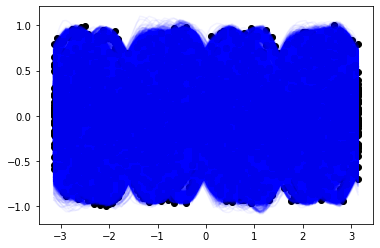

In [78]:
batch_size = 2

error_matrix = []

for num_context in range(1, 20):
    error_context = []
    print(num_context)
    for num_target in range(1, 20):
        global_error = 0
        print(num_target)

        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
        np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

        neuralprocess.training = True
        total_loss, epoch_loss = np_trainer.train(data_loader, 10)


        # Extract a batch from data_loader
        for batch in data_loader:
            break

        # Use batch to create random set of context points
        x, y = batch
        x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

        # Create a set of target points corresponding to entire [-pi, pi] range
        x_target = torch.Tensor(np.linspace(-pi, pi, 100))
        x_target = x_target.unsqueeze(1).unsqueeze(0)

        neuralprocess.training = False

        for i in range(num_tests):
            # Neural process returns distribution over y_target
            p_y_pred = neuralprocess(x_context, y_context, x_target)
            # Extract mean of distribution
            mu = p_y_pred.loc.detach()
            plt.plot(x_target.numpy()[0], mu.numpy()[0], alpha=0.05, c='b')
    
            y_cont = []
            for i in range(len(y_context[0].numpy())):
                y_cont.append(y_context[0].numpy()[i][0])
            y_cont = np.array(y_cont) 
            L = []
            for i in range(len(x_context[0].numpy())):
                ind = int(len(x_target.numpy()[0]) * (np.pi + x_context[0].numpy()[i])/(2*np.pi))
                if ind == len(mu.numpy()[0]):
                    ind = ind-1
                point_pred = mu.numpy()[0][ind][0]
                L.append(point_pred)
            L = np.array(L)
            error = np.linalg.norm(y_cont - L)/(len(x_context[0])**0.5)
            global_error += error
    
        global_error = global_error/num_tests
        error_context.append(global_error)
        plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')
    error_matrix.append(error_context)

In [79]:
np.array(error_matrix)

array([[0.10732694, 0.16626684, 0.20949859, 0.19897855, 0.34808904,
        0.04022556, 0.22027005, 0.02175586, 0.30937735, 0.54388408,
        0.66523064, 0.35565859, 0.00489623, 0.05371919, 0.14759971,
        0.00424757, 0.55556591, 0.25413753, 0.72982775],
       [0.46731538, 0.11800291, 0.53026316, 0.3476288 , 0.60765238,
        0.37113634, 0.53511712, 0.11827357, 0.24499335, 0.58578178,
        0.00533302, 0.02578432, 0.57953662, 0.17215137, 0.22771406,
        0.20717294, 0.36041456, 0.11184625, 0.08766545],
       [0.16103557, 0.08861928, 0.07219956, 0.07917051, 0.36455149,
        0.08149414, 0.24732771, 0.15821766, 0.22196666, 0.05491225,
        0.15259778, 0.15374178, 0.24379677, 0.13246982, 0.40440515,
        0.10111097, 0.05533799, 0.33538496, 0.08671409],
       [0.12372427, 0.22161094, 0.05825189, 0.14566861, 0.07150618,
        0.05257219, 0.12539317, 0.07170636, 0.04326605, 0.16556386,
        0.08161311, 0.07203912, 0.08584565, 0.08083275, 0.22687658,
        0.607

<Figure size 720x360 with 0 Axes>

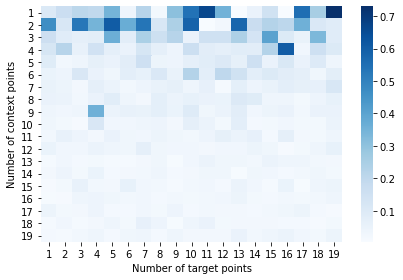

'\nplt.figure(figsize=(10,5))\nfig, ax = plt.subplots()\ndf = pd.DataFrame(error_matrix).set_index([pd.Index([i for i in range(1, 20)])]).transpose().set_index([pd.Index([i for i in range(1, 20)])]).transpose()\nseaborn.heatmap(df, cmap = \'Spectral\', cbar = True)\nax.set_xlabel("Number of target points")\nax.set_ylabel("Number of context points")\nplt.tight_layout()\nplt.show()\n'

In [87]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
df = pd.DataFrame(error_matrix).set_index([pd.Index([i for i in range(1, 20)])]).transpose().set_index([pd.Index([i for i in range(1, 20)])]).transpose()
seaborn.heatmap(df, cmap = 'Blues', cbar = True)
ax.set_xlabel("Number of target points")
ax.set_ylabel("Number of context points")
plt.tight_layout()
plt.show()

"""
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
df = pd.DataFrame(error_matrix).set_index([pd.Index([i for i in range(1, 20)])]).transpose().set_index([pd.Index([i for i in range(1, 20)])]).transpose()
seaborn.heatmap(df, cmap = 'Spectral', cbar = True)
ax.set_xlabel("Number of target points")
ax.set_ylabel("Number of context points")
plt.tight_layout()
plt.show()
"""

# RMSE - check for one curve

0.02368598305232202


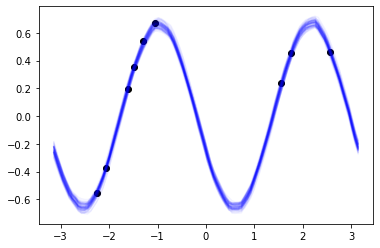

In [72]:
#RMSE - error for one training OK

from utils import context_target_split
num_tests = 64
# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False
global_error = 0

for i in range(num_tests):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], alpha=0.05, c='b')
    
    y_cont = []
    for i in range(len(y_context[0].numpy())):
        y_cont.append(y_context[0].numpy()[i][0])
    y_cont = np.array(y_cont) 
    L = []
    for i in range(len(x_context[0].numpy())):
        ind = int(len(x_target.numpy()[0]) * (np.pi + x_context[0].numpy()[i])/(2*np.pi))
        point_pred = mu.numpy()[0][ind][0]
        L.append(point_pred)
    L = np.array(L)
    error = np.linalg.norm(y_cont - L)/(len(x_context[0])**0.5)
    global_error += error
    #print(error)
    
global_error = global_error/num_tests
print(global_error)
plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

In [94]:
y_cont = []
for i in range(len(y_context[0].numpy())):
    y_cont.append(y_context[0].numpy()[i][0])
y_cont = np.array(y_cont)

In [95]:
L = []
for i in range(len(x_context[0].numpy())):
    ind = int(len(x_target.numpy()[0]) * (np.pi + x_context[0].numpy()[i])/(2*np.pi))
    point_pred = mu.numpy()[0][ind][0]
    L.append(point_pred)
L = np.array(L)

In [98]:
error = np.linalg.norm(y_cont - L)/(len(x_context[0])**0.5)

In [99]:
error

0.19860701262950897

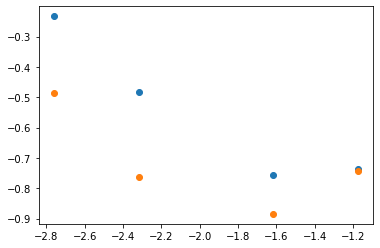

In [97]:
plt.scatter(x_context[0].numpy(), np.array(L))
plt.scatter(x_context[0].numpy(), y_context[0].numpy())

# Saved with nums between 1 and 9, 30000 epochs for training

In [ ]:
#dataset = SineData(amplitude_range=(-1., 1.),
#                   shift_range=(-0.5, 0.5),
#                  num_samples=2000)

In [53]:
error_matrix_saved_1 = error_matrix.copy()

<Figure size 720x360 with 0 Axes>

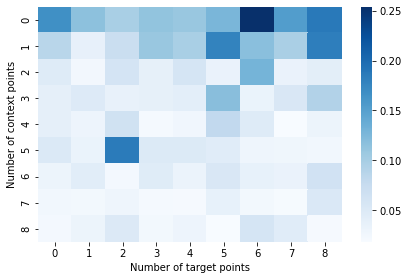

<Figure size 720x360 with 0 Axes>

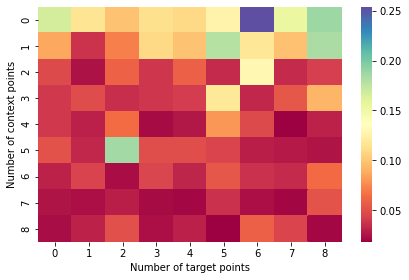

In [52]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
df = pd.DataFrame(error_matrix)
seaborn.heatmap(df, cmap = 'Blues', cbar = True)
ax.set_xlabel("Number of target points")
ax.set_ylabel("Number of context points")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
df = pd.DataFrame(error_matrix)
seaborn.heatmap(df, cmap = 'Spectral', cbar = True)
ax.set_xlabel("Number of target points")
ax.set_ylabel("Number of context points")
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

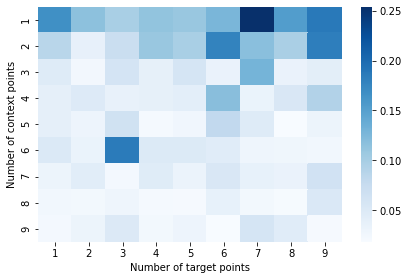

<Figure size 720x360 with 0 Axes>

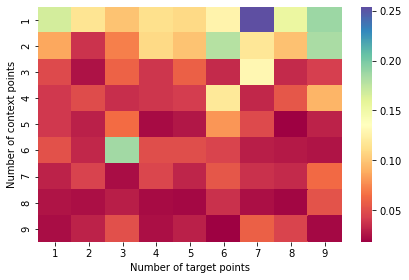

In [71]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
df = pd.DataFrame(error_matrix).set_index([pd.Index([1, 2, 3, 4, 5, 6, 7, 8, 9])]).transpose().set_index([pd.Index([1, 2, 3, 4, 5, 6, 7, 8, 9])]).transpose()
seaborn.heatmap(df, cmap = 'Blues', cbar = True)
ax.set_xlabel("Number of target points")
ax.set_ylabel("Number of context points")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
df = pd.DataFrame(error_matrix).set_index([pd.Index([1, 2, 3, 4, 5, 6, 7, 8, 9])]).transpose().set_index([pd.Index([1, 2, 3, 4, 5, 6, 7, 8, 9])]).transpose()
seaborn.heatmap(df, cmap = 'Spectral', cbar = True)
ax.set_xlabel("Number of target points")
ax.set_ylabel("Number of context points")
plt.tight_layout()
plt.show()